In [4]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
# import model
import model_refine as model
import time

from sklearn.manifold import TSNE

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Read in the data matrices of Human PBMC
Profile ASAP-Seq and CITE-Seq before and after T cell stimulation. PBMCs are separated into two groups, one is stimulated with anti-CD3/CD28 and IL-2 for 6h, the other one is the control group. Each group is further splited to run ASAP-Seq and CITE-Seq separately.

In [2]:
dir = '../data/real/ASAP-PBMC/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in range(1,5):
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    try:
        counts_protein = np.array(sp.load_npz(os.path.join(dir, 'PxC' + str(batch) + ".npz")).todense().T)
        counts_protein = utils.preprocess(counts_protein, modality = "RNA")
        
    except:
        counts_protein = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)
    counts_proteins.append(counts_protein)

counts = {"rna":counts_rnas, "atac": counts_atacs, "protein": counts_proteins}

A1 = sp.load_npz(os.path.join(dir, 'GxP.npz'))
A2 = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A1 = np.array(A1.todense())
A2 = np.array(A2.todense())
A1 = utils.preprocess(A1, modality = "gact")
A2 = utils.preprocess(A2, modality = "gact")

interacts = {"rna_atac": A2, "rna_protein": A1}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()
proteins = pd.read_csv(dir + "proteins.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions, "protein": proteins}
counts["feats_name"] = feats_name

In [3]:
print("no interaction")
aris = np.load("../test/results_pbmc_dims/aris.npy").squeeze()
aris1 = aris[:6]
aris2 = aris[6:12]
aris3 = aris[12:]
aris = pd.DataFrame(data = aris.reshape(3,6), columns = [10, 13, 15, 17, 20, 30], index = ["lr = 1e-2, T = 4000", "lr = 5e-3, T = 4000", "lr = 5e-3, T = 10000"])
display(aris)

print("with interaction")
aris = np.load("../test/results_pbmc_dims/aris2.npy").squeeze()
aris1 = aris[:6]
aris2 = aris[6:12]
aris3 = aris[12:]
aris = pd.DataFrame(data = aris.reshape(3,6), columns = [10, 13, 15, 17, 20, 30], index = ["lr = 1e-2, T = 4000", "lr = 5e-3, T = 4000", "lr = 5e-3, T = 10000"])
display(aris)

no interaction


10        13        15        17        20  \
lr = 1e-2, T = 4000   0.289189  0.342548  0.265112  0.146105  0.130973   
lr = 5e-3, T = 4000   0.380222  0.388943  0.364041  0.288458  0.187420   
lr = 5e-3, T = 10000  0.321653  0.367103  0.218993  0.264600  0.210985   

                            30  
lr = 1e-2, T = 4000   0.127432  
lr = 5e-3, T = 4000   0.178358  
lr = 5e-3, T = 10000  0.163070

with interaction


10        13        15        17        20  \
lr = 1e-2, T = 4000   0.324759  0.351838  0.328308  0.296996  0.278310   
lr = 5e-3, T = 4000   0.323579  0.304710  0.368583  0.269199  0.239378   
lr = 5e-3, T = 10000  0.362501  0.245405  0.285965  0.260001  0.271196   

                            30  
lr = 1e-2, T = 4000   0.226265  
lr = 5e-3, T = 4000   0.259046  
lr = 5e-3, T = 10000  0.284807

In [13]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.0]
batchsize = 0.1
run = 0
# better with 13

K = 13
Ns = [K] * 4
N_feat = K

# K = 8
# Ns = [K] * 4
# N_feat = 8
interval = 100
T = 4000
lr = 5e-3

In [14]:
# didn't use the interaction matrix
model1 = model.cfrm_new2(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -133.0840
	 loss 1: 166.84752
	 loss 2: 0.00000
	 loss 3: -299.93155
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: -133.0677
	 loss 1: 166.93208
	 loss 2: 0.00000
	 loss 3: -299.99982
	 loss 4: 0.00000
	 loss 5: 0.00000
1
Epoch 300, Validating Loss: -133.2143
	 loss 1: 166.78482
	 loss 2: 0.00000
	 loss 3: -299.99908
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: -134.5091
	 loss 1: 165.46568
	 loss 2: 0.00000
	 loss 3: -299.97476
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: -139.2413
	 loss 1: 160.73344
	 loss 2: 0.00000
	 loss 3: -299.97473
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: -143.7849
	 loss 1: 156.18898
	 loss 2: 0.00000
	 loss 3: -299.97385
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: -146.4759
	 loss 1: 153.51614
	 loss 2: 0.00000
	 loss 3: -299.99200
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: -147.96

In [15]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


In [20]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 5]
batchsize = 0.1
run = 0
# better with 13

K = 30
Ns = [K] * 4
N_feat = K

# K = 8
# Ns = [K] * 4
# N_feat = 8
interval = 100
T = 6000
lr = 1e-2

# didn't use the interaction matrix
model1 = model.cfrm_vanilla(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T)

Input sanity check...
Finished.
loss1_sub: 8.7199e-03
loss1_sub: 1.4951e-02
loss1_sub: 9.3684e-03
loss1_sub: 1.5489e-02
loss1_sub: 4.5444e-02
loss1_sub: 1.5189e-02
loss1_sub: 4.5000e-02
loss1_sub: 1.2531e-02
Epoch 100, Validating Loss: 166.7778
	 loss 1: 0.16669
	 loss 2: 0.08593
	 loss 3: 0.00000
loss1_sub: 8.6912e-03
loss1_sub: 1.4234e-02
loss1_sub: 9.3312e-03
loss1_sub: 1.4730e-02
loss1_sub: 4.5393e-02
loss1_sub: 1.4587e-02
loss1_sub: 4.4948e-02
loss1_sub: 1.1974e-02
Epoch 200, Validating Loss: 163.8890
	 loss 1: 0.16389
	 loss 2: 0.00117
	 loss 3: 0.00000
loss1_sub: 8.6225e-03
loss1_sub: 1.3217e-02
loss1_sub: 9.2533e-03
loss1_sub: 1.3702e-02
loss1_sub: 4.5188e-02
loss1_sub: 1.3627e-02
loss1_sub: 4.4759e-02
loss1_sub: 1.1156e-02
Epoch 300, Validating Loss: 159.5264
	 loss 1: 0.15952
	 loss 2: 0.00240
	 loss 3: 0.00000
loss1_sub: 8.5512e-03
loss1_sub: 1.2502e-02
loss1_sub: 9.1847e-03
loss1_sub: 1.3029e-02
loss1_sub: 4.4831e-02
loss1_sub: 1.2887e-02
loss1_sub: 4.4395e-02
loss1_sub: 1.

loss1_sub: 7.9846e-03
loss1_sub: 1.0757e-02
loss1_sub: 8.7321e-03
loss1_sub: 1.1122e-02
loss1_sub: 4.2390e-02
loss1_sub: 1.1347e-02
loss1_sub: 4.2084e-02
loss1_sub: 9.3332e-03
Epoch 3200, Validating Loss: 143.7723
	 loss 1: 0.14375
	 loss 2: 0.02353
	 loss 3: 0.00000
loss1_sub: 7.9786e-03
loss1_sub: 1.0741e-02
loss1_sub: 8.7242e-03
loss1_sub: 1.1123e-02
loss1_sub: 4.2381e-02
loss1_sub: 1.1317e-02
loss1_sub: 4.2074e-02
loss1_sub: 9.3070e-03
Epoch 3300, Validating Loss: 143.6704
	 loss 1: 0.14365
	 loss 2: 0.02430
	 loss 3: 0.00000
loss1_sub: 7.9781e-03
loss1_sub: 1.0728e-02
loss1_sub: 8.7203e-03
loss1_sub: 1.1077e-02
loss1_sub: 4.2376e-02
loss1_sub: 1.1318e-02
loss1_sub: 4.2073e-02
loss1_sub: 9.3261e-03
Epoch 3400, Validating Loss: 143.6185
	 loss 1: 0.14360
	 loss 2: 0.02080
	 loss 3: 0.00000
loss1_sub: 7.9752e-03
loss1_sub: 1.0711e-02
loss1_sub: 8.7173e-03
loss1_sub: 1.1046e-02
loss1_sub: 4.2373e-02
loss1_sub: 1.1342e-02
loss1_sub: 4.2063e-02
loss1_sub: 9.2943e-03
Epoch 3500, Validati

## Visualize cell embedding
Extract cell factor and perform UMAP visualization

In [25]:
# umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 
umap_op = UMAP(n_components = 2, n_neighbors = 5, min_dist = 0.1, random_state = 0) 
tsne_op = TSNE(n_components = 2)
zs = []
labels = []
prec_labels = []
cfrm_labels = []
for batch in range(0,4):
    z = model1.softmax(model1.C_cells[str(batch)].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    cfrm_labels.append(np.argmax(z, axis = 1).squeeze())

labels_tmp = utils.leiden_cluster(np.concatenate(zs, axis = 0), resolution = 0.5)
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

# separate into batches
x_umaps = []
leiden_labels = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])
        
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
        leiden_labels.append(labels_tmp[start_pointer:])
        
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])

# for batch in range(0,4):
#     z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
#     np.save(file = "./pancreas/cell_factors/C_batch" + str(batch) + ".npy", arr = z)


### Ground truth labeling

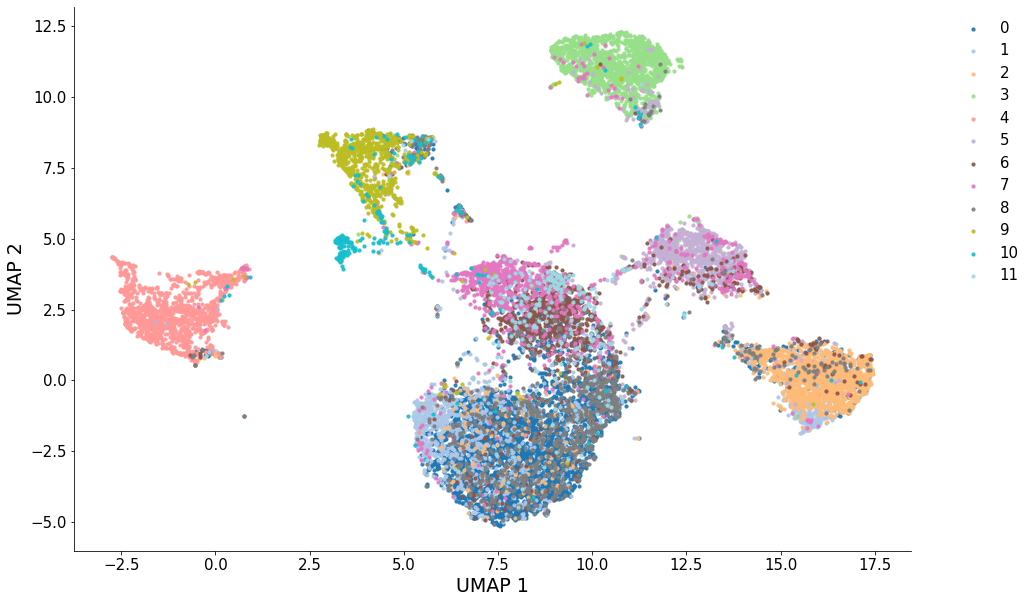

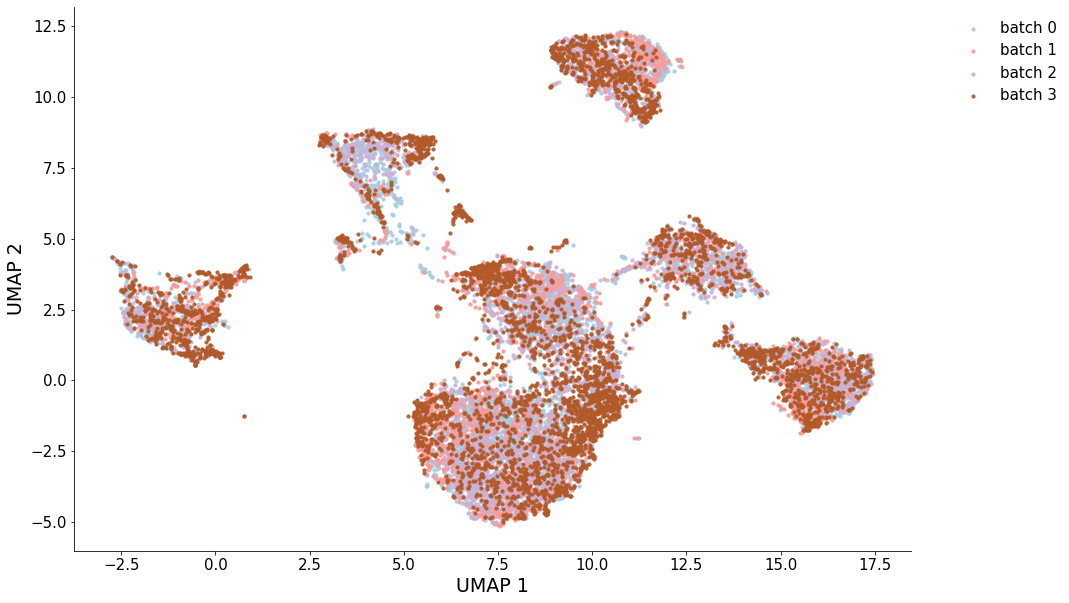

In [26]:
save_file = "./PBMC/umap_celltypes.png"
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP")
save_file = "./PBMC/umap_batches.png"
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP")


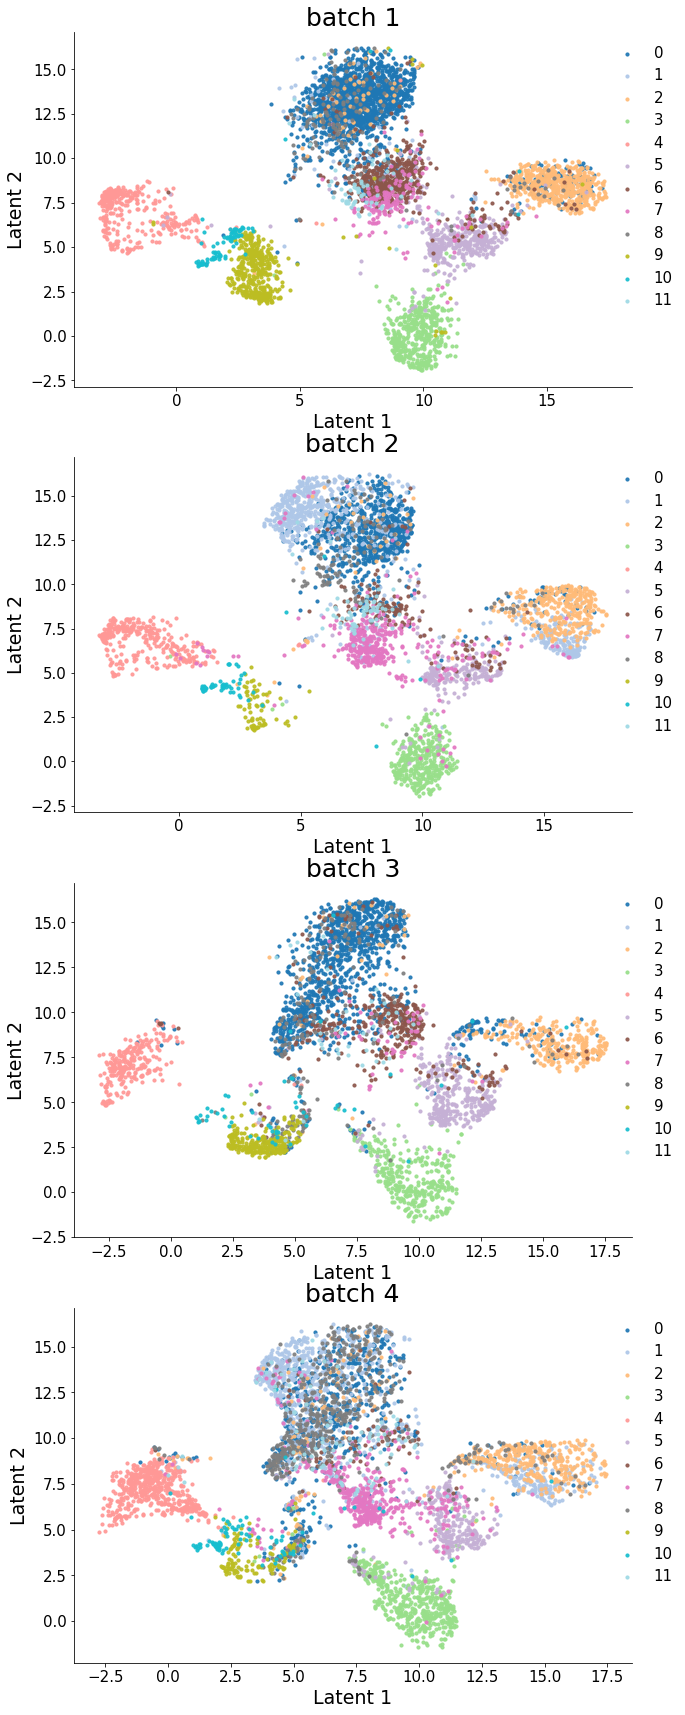

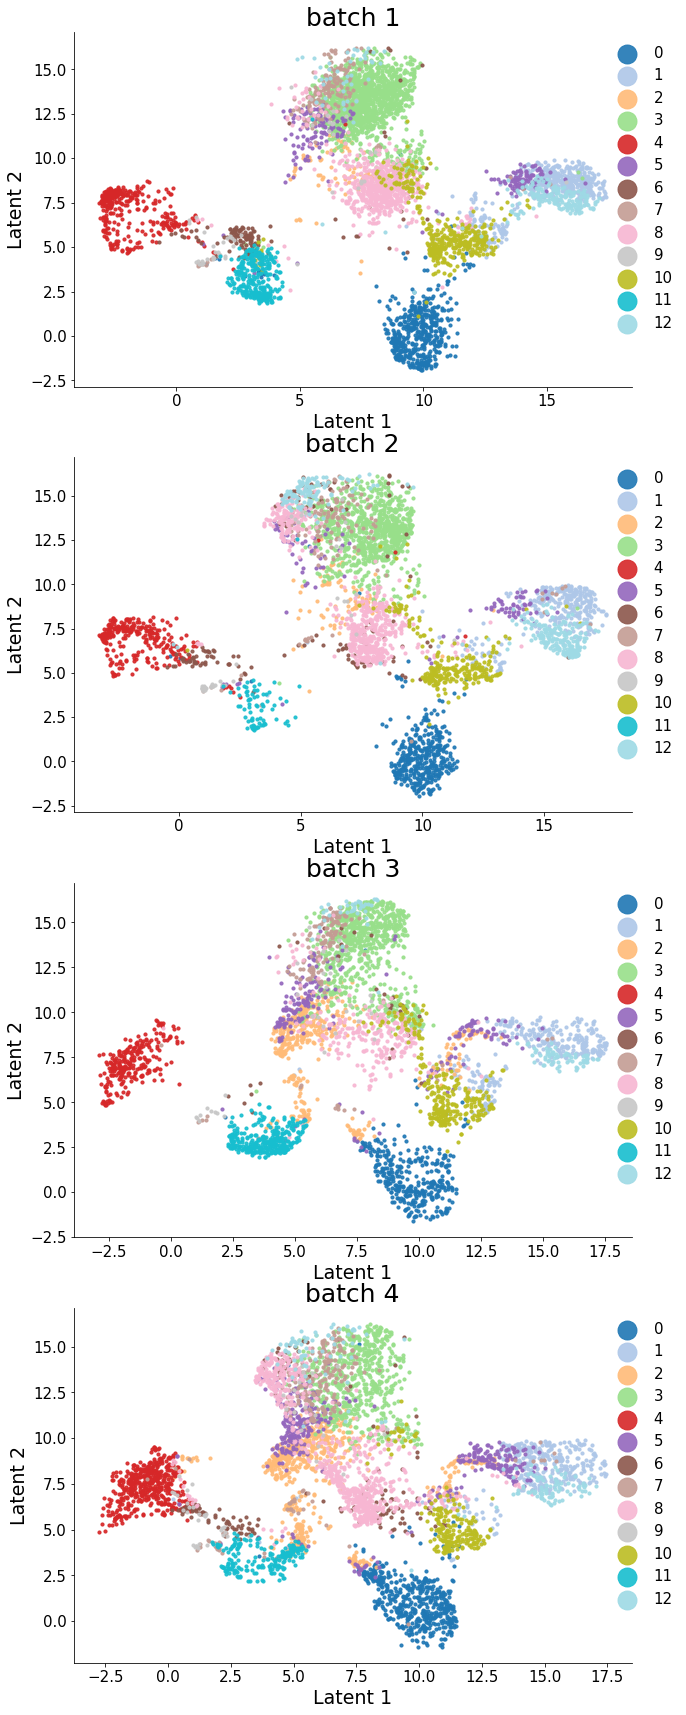

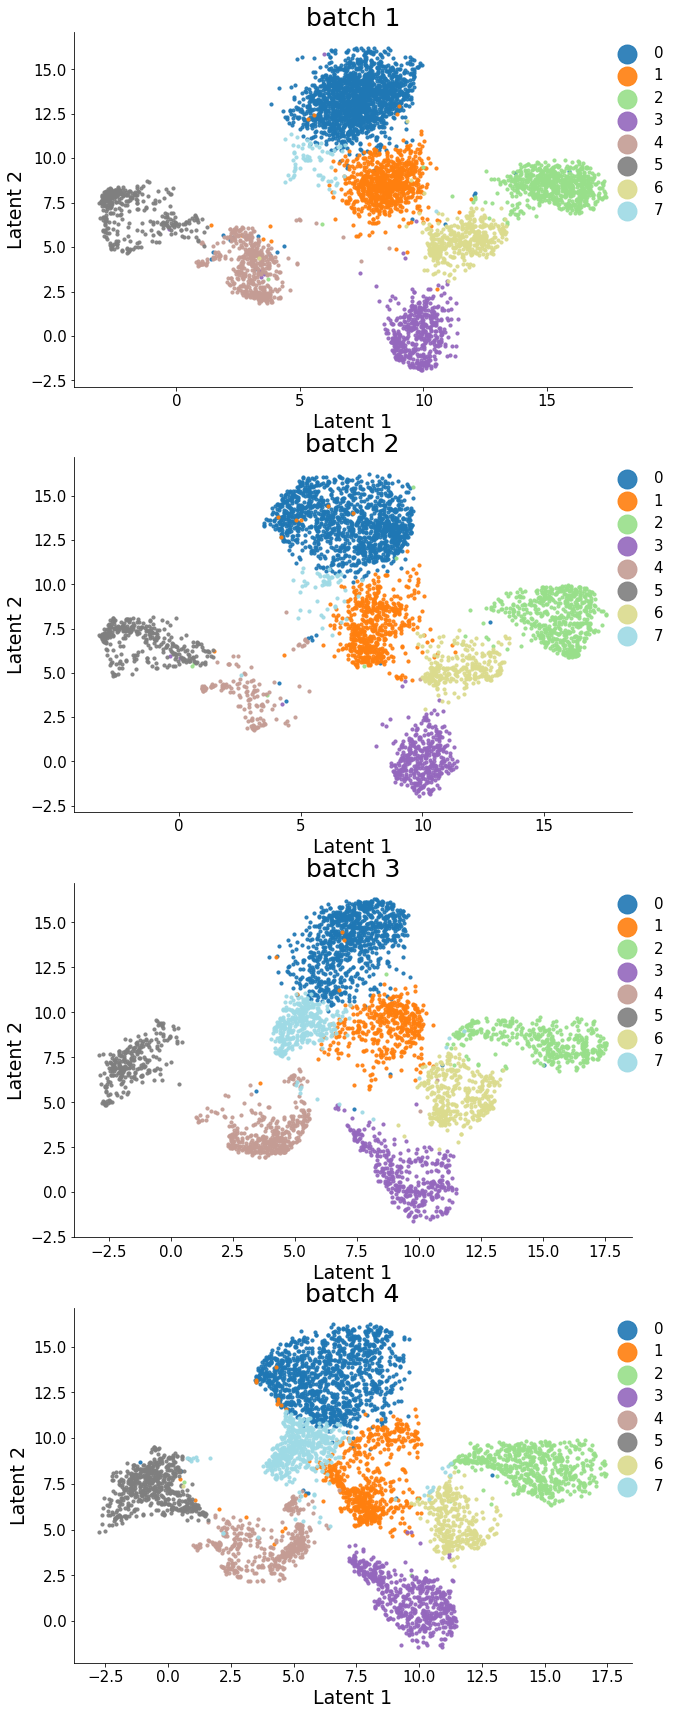

In [59]:
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")
utils.plot_latent_ext(x_umaps, annos = cfrm_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)
utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)


### Prediction of scJMT

In [60]:
import importlib 
importlib.reload(utils)

<module 'utils' from '../src/utils.py'>

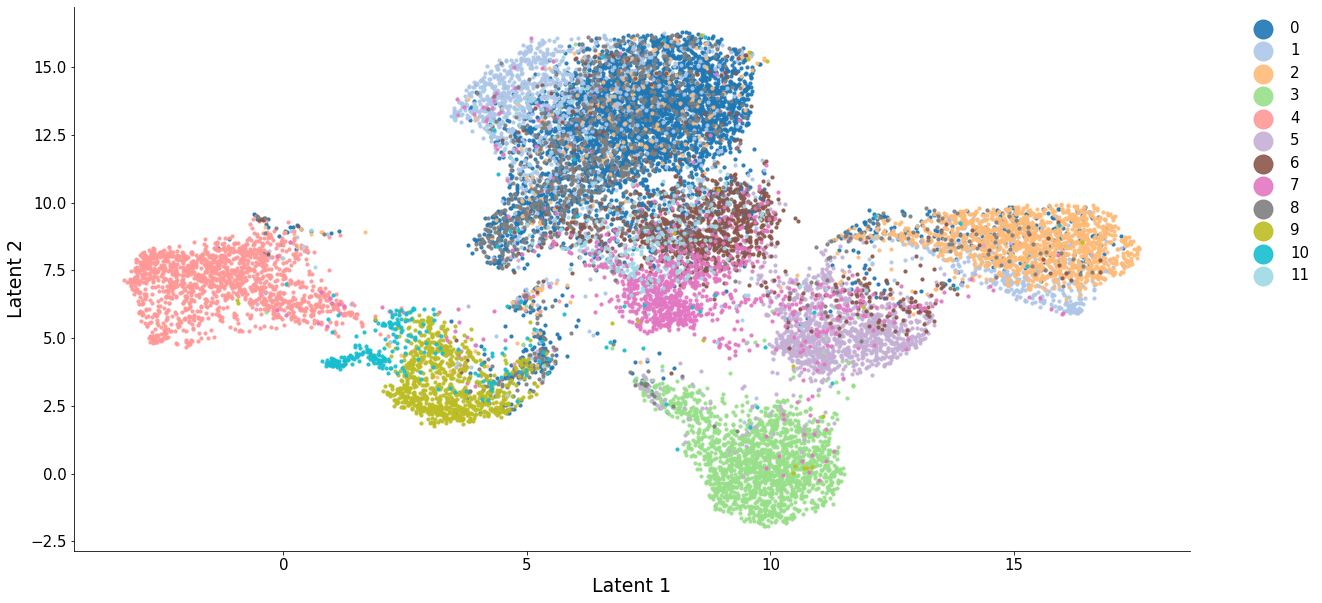

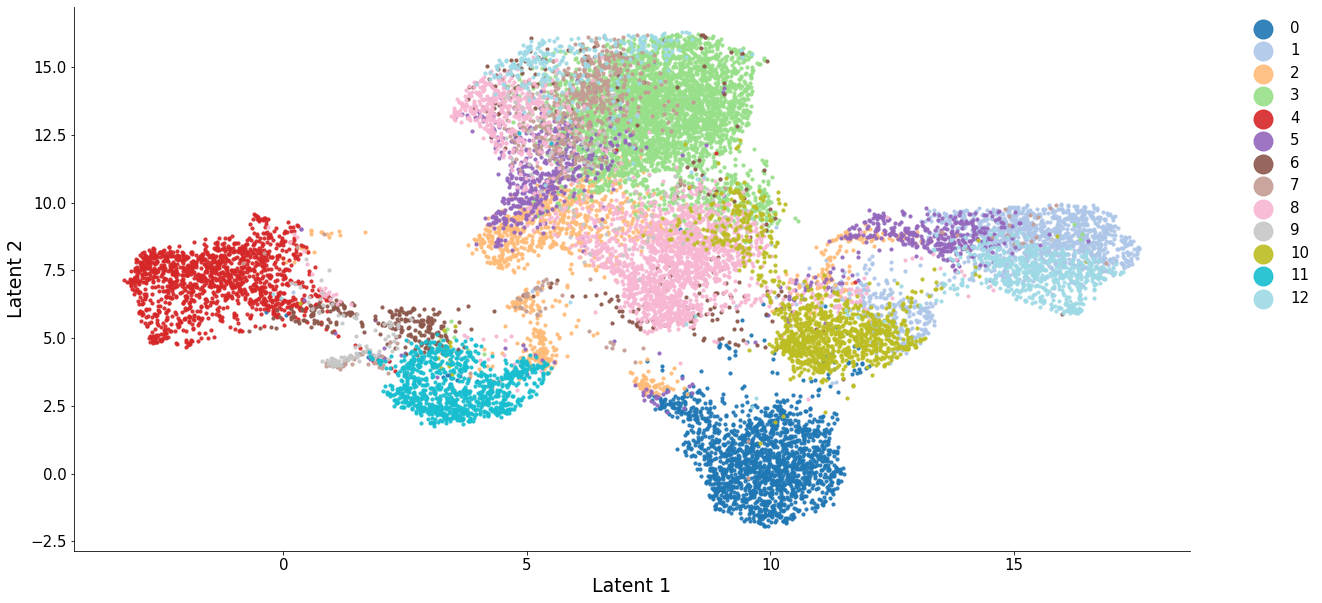

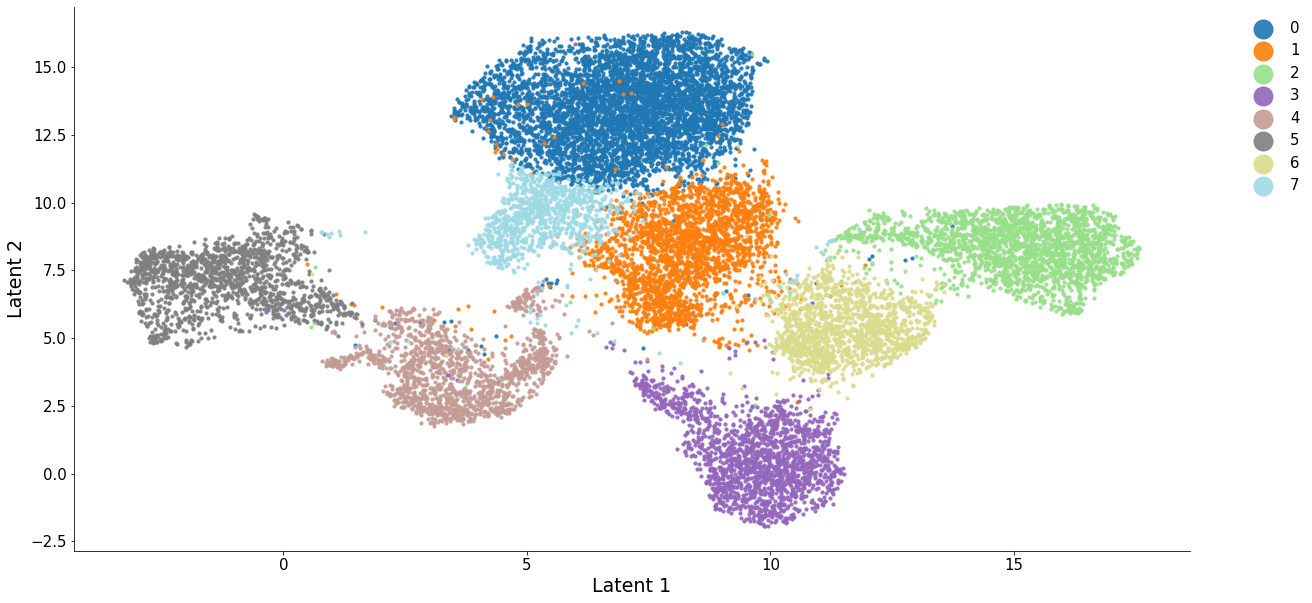

In [61]:
# utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = "PBMC/plots/umap_mod.png", 
#                       figsize = (20,10), axis_label = "Latent", markerscale = 6)

# utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = "PBMC/plots/umap_label_I.png", 
#                       figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = cfrm_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


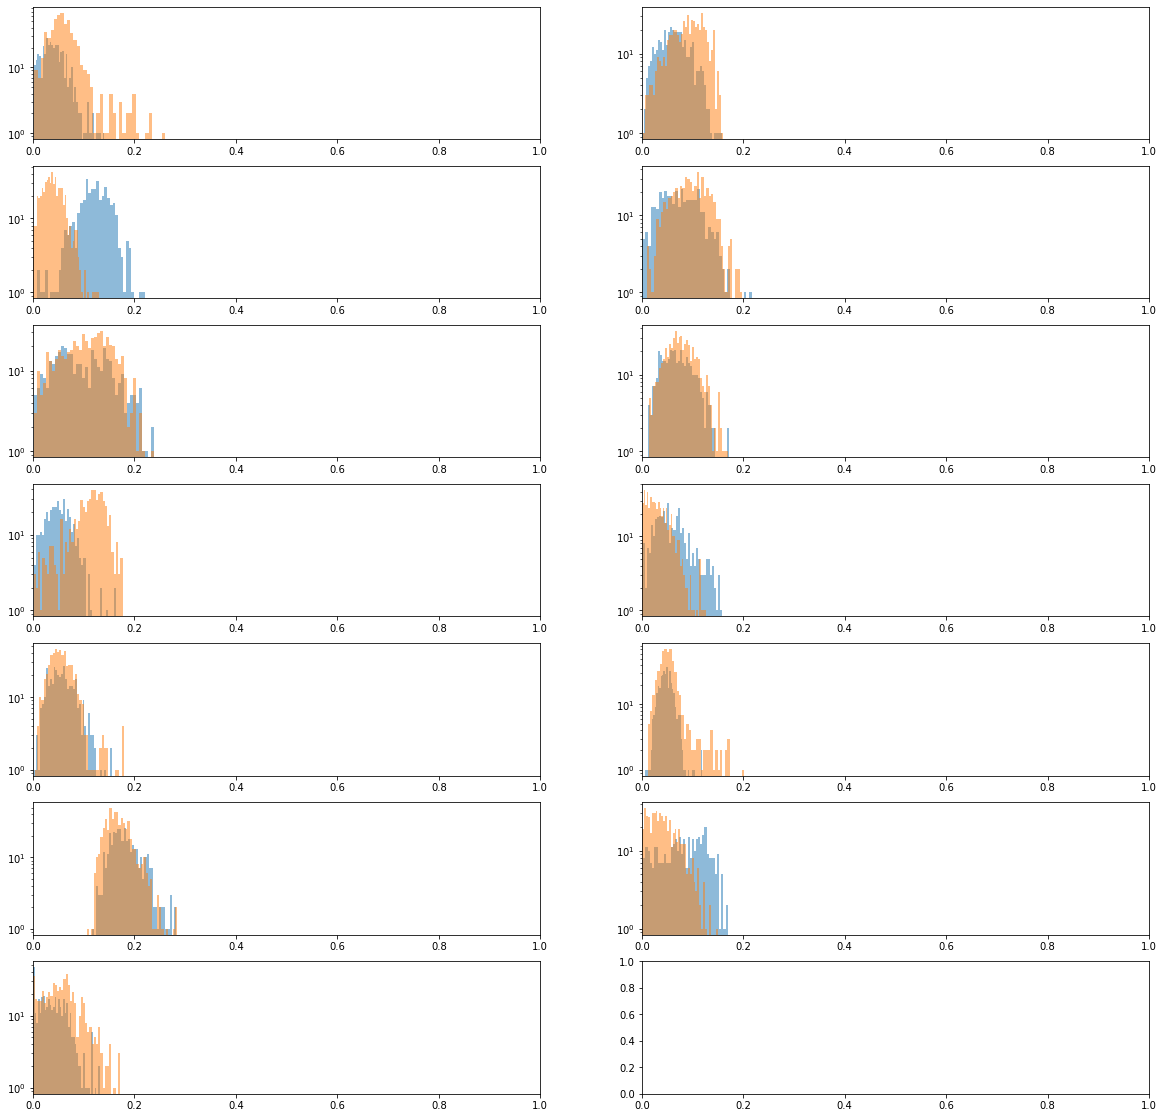

In [62]:
cfrm_label = np.concatenate(cfrm_labels, axis = 0)

sub_clust1 = np.where((cfrm_label == 5) & (x_umap[:,0] > 10))[0]
sub_clust2 = np.where((cfrm_label == 5) & (x_umap[:,0] <= 10))[0]

zs2 = np.concatenate(zs)
zs_sub1 = zs2[sub_clust1, :]
zs_sub2 = zs2[sub_clust2, :]


nrows = np.ceil(zs2.shape[1]/2).astype('int32')
ncols = 2
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(zs2.shape[1]):
    _ = axs[i%nrows, i//nrows].hist(zs_sub1[:, i], bins = 40, alpha = 0.5)
    _ = axs[i%nrows, i//nrows].hist(zs_sub2[:, i], bins = 40, alpha = 0.5)
    axs[i%nrows, i//nrows].set_xlim([0,1])
    axs[i%nrows, i//nrows].set_yscale('log')

In [63]:
# # gene clusters, original
# counts_gene = utils.preprocess_old(np.concatenate([x.T for x in counts["rna"] if x is not None], axis = 1), mode = "standard", modality = "RNA")
# gene_umap = umap_op.fit_transform(counts_gene)

# z = model1.softmax(model1.C_feats[0].cpu().detach()).numpy()
# pre_labels = [np.argmax(z, axis = 1).squeeze()]

# utils.plot_latent_ext([gene_umap], annos = pre_labels, mode = "joint", save = None, figsize = (10,7), axis_label = "Latent")

# # gene clusters, gene factor
# gene_umap = umap_op.fit_transform(z)

# utils.plot_latent_ext([gene_umap], annos = pre_labels, mode = "joint", save = None, figsize = (10,7), axis_label = "Latent")

# # from sklearn.cluster import KMeans
# # from seaborn import heatmap
# # gene_umap = umap_op.fit_transform(counts_gene)
# # kmeans = KMeans(n_clusters = 2, random_state = 0).fit(gene_umap)
# # kmeans_label = kmeans.labels_
# # utils.plot_latent_ext([gene_umap], annos = [kmeans_label], mode = "joint", save = None, figsize = (10,7), axis_label = "Latent")


In [64]:
# prec_labels = []
# x_umaps = []

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 

counts_protein = utils.preprocess_old(np.concatenate([counts["protein"][x] for x in range(4)], axis = 0), mode = "standard", modality = "RNA")
x_umap = umap_op.fit_transform(counts_protein)


x_umaps = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts["protein"][batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + counts["protein"][batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts["protein"][batch - 1].shape[0]
        end_pointer = start_pointer + counts["protein"][batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

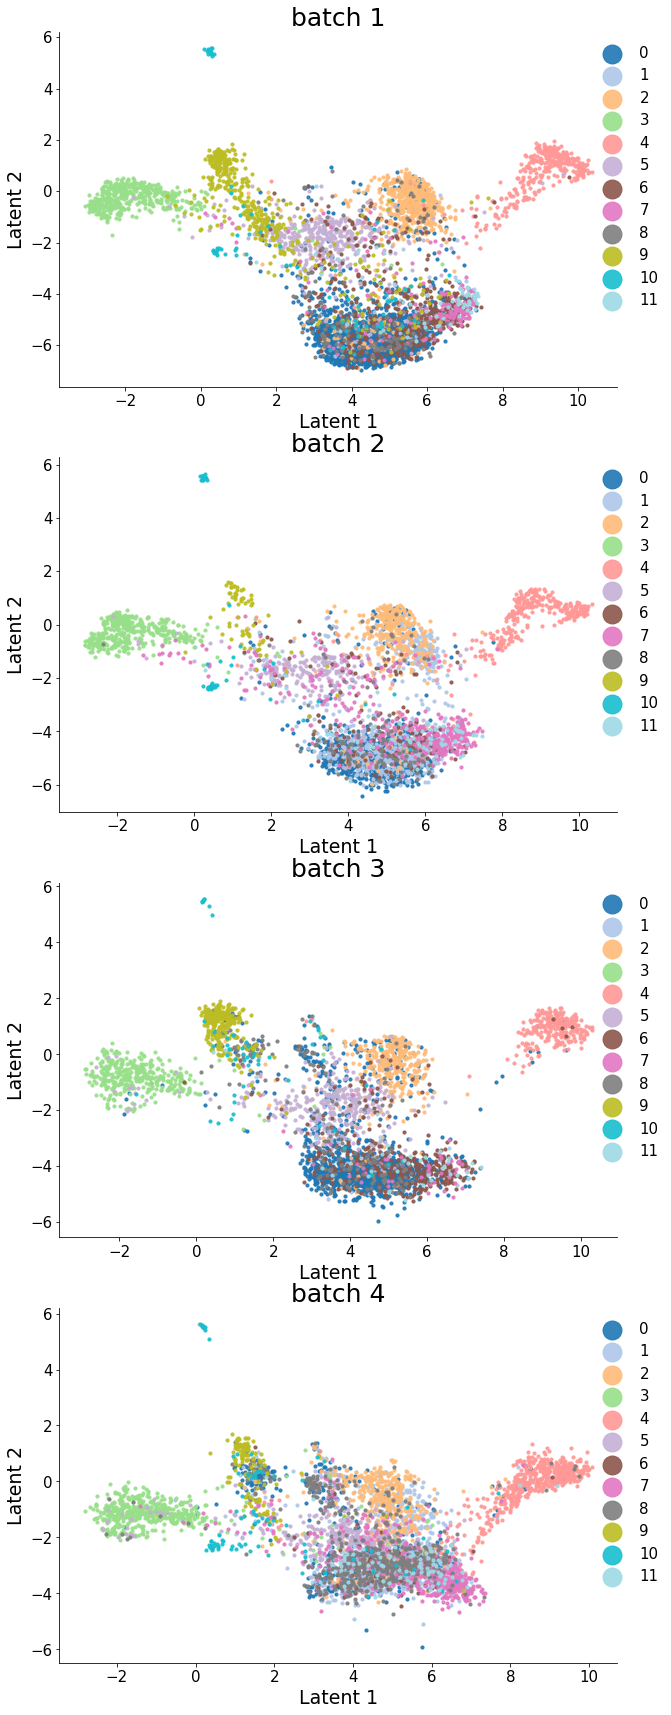

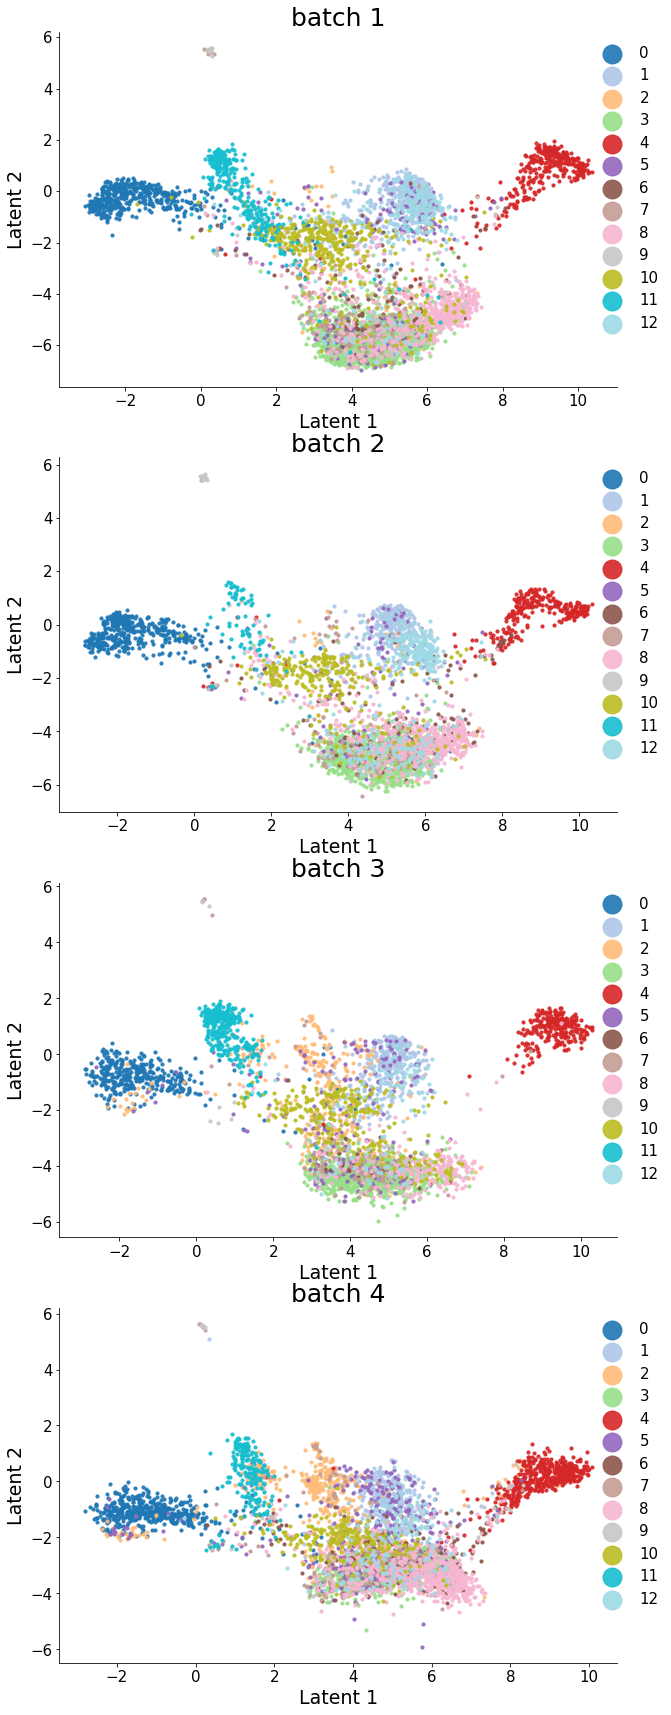

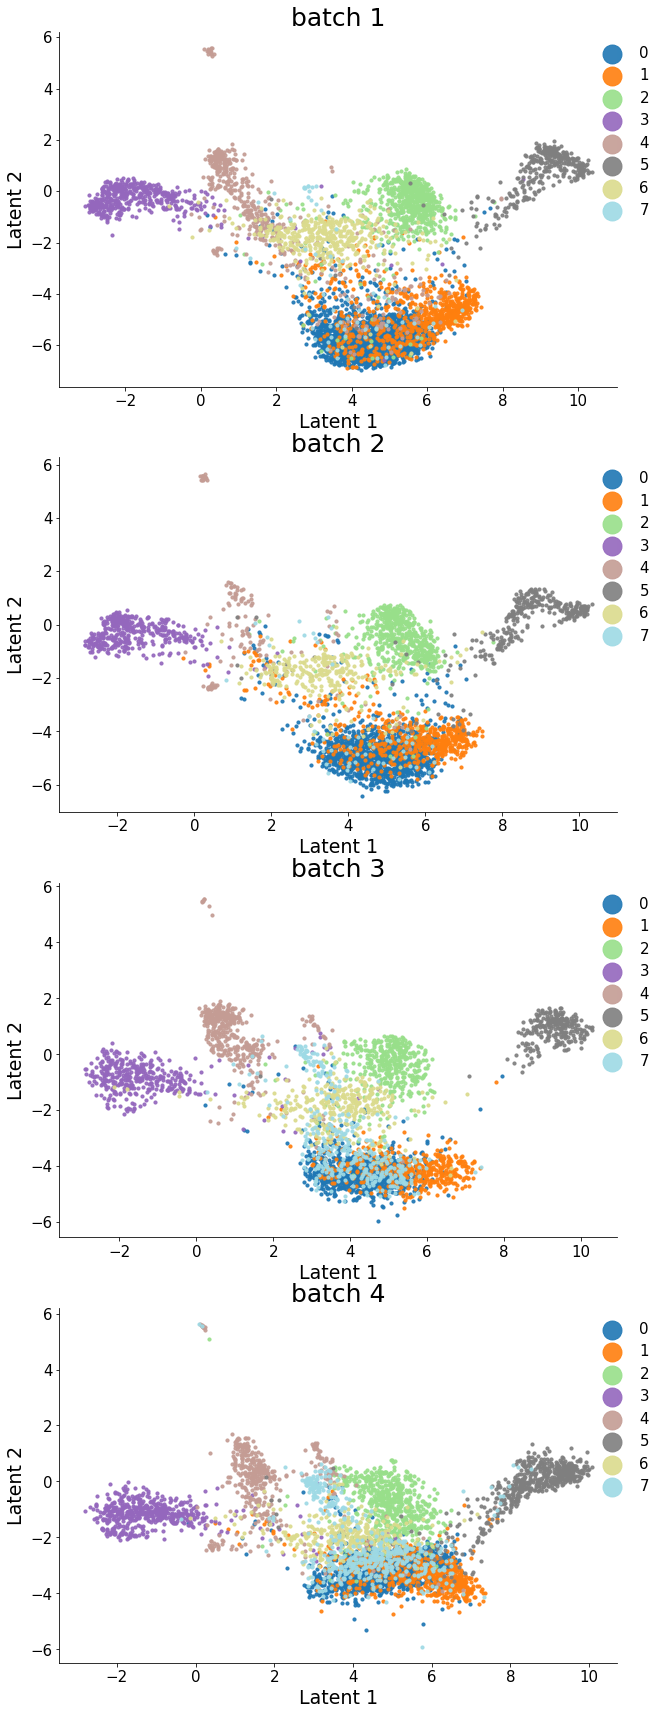

In [65]:
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)
utils.plot_latent_ext(x_umaps, annos = cfrm_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)
utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)


In [66]:
# def lsi_ATAC(X, k = 100, use_first = False):
#     """\
#     Description:
#     ------------
#         Compute LSI with TF-IDF transform, i.e. SVD on document matrix, can do tsne on the reduced dimension

#     Parameters:
#     ------------
#         X: cell by feature(region) count matrix
#         k: number of latent dimensions
#         use_first: since we know that the first LSI dimension is related to sequencing depth, we just ignore the first dimension since, and only pass the 2nd dimension and onwards for t-SNE
    
#     Returns:
#     -----------
#         latent: cell latent matrix
#     """    
#     from sklearn.feature_extraction.text import TfidfTransformer
#     from sklearn.decomposition import TruncatedSVD

#     # binarize the scATAC-Seq count matrix
#     bin_X = np.where(X < 1, 0, 1)
    
#     # perform Latent Semantic Indexing Analysis
#     # get TF-IDF matrix
#     tfidf = TfidfTransformer(norm='l2', sublinear_tf=True)
#     normed_count = tfidf.fit_transform(bin_X)

#     # perform SVD on the sparse matrix
#     lsi = TruncatedSVD(n_components = k, random_state=42)
#     lsi_r = lsi.fit_transform(normed_count)
    
#     # use the first component or not
#     if use_first:
#         return lsi_r
#     else:
#         return lsi_r[:, 1:]

# pre_labels = []
# prec_labels = []
# x_umaps = []
# umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4) 
# # for batch in range(4):
# #     counts_protein = utils.preprocess_old(counts["protein"][batch], mode = "standard", modality = "RNA")
# #     protein_umap = umap_op.fit_transform(counts_protein)
# #     x_umaps.append(protein_umap)
# #     prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
# #     z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
# #     pre_labels.append(np.argmax(z, axis = 1).squeeze())

# # utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)

# for batch in range(2,4):
#     counts_atac = utils.preprocess_old(counts["atac"][batch], mode = "standard", modality = "ATAC")
#     counts_atac = lsi_ATAC(counts_atac)
#     atac_umap = umap_op.fit_transform(counts_atac)
#     x_umaps.append(atac_umap)
#     prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
#     z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
#     pre_labels.append(np.argmax(z, axis = 1).squeeze())
    

# utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent", markerscale = 6)


### New cluster assignment

In [16]:
# umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
tsne_op = TSNE(n_components = 2)
zs = []
labels = []
prec_labels = []
cfrm_labels = []
for batch in range(0,4):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    cfrm_labels.append(np.argmax(z, axis = 1).squeeze())

labels_tmp = utils.leiden_cluster(np.concatenate(zs, axis = 0), resolution = 0.5)
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

# separate into batches
x_umaps = []
leiden_labels = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])
        
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
        leiden_labels.append(labels_tmp[start_pointer:])
        
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
        leiden_labels.append(labels_tmp[start_pointer:end_pointer])

# for batch in range(0,4):
#     z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
#     np.save(file = "./pancreas/cell_factors/C_batch" + str(batch) + ".npy", arr = z)

In [17]:
def kmeans_factor(C_cells):
    from sklearn.cluster import KMeans
    # fix the number of clusters
    n_clusts = C_cells.shape[1]
    init_centroid = np.eye(n_clusts)
    kmeans = KMeans(n_clusters = n_clusts, init = init_centroid, n_init = 1).fit(C_cells)
    new_centroid = kmeans.cluster_centers_
    labels = kmeans.labels_
    return new_centroid, labels

C_cells = np.concatenate(zs, axis = 0)
kmeans_centroid, labels = kmeans_factor(C_cells)

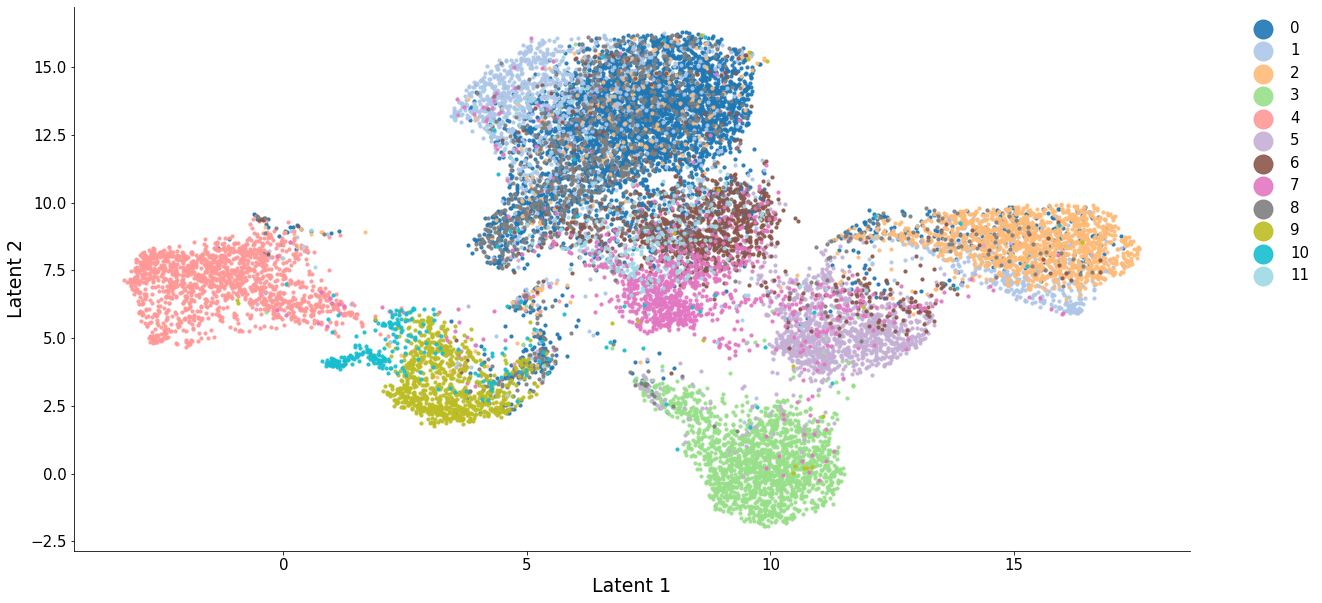

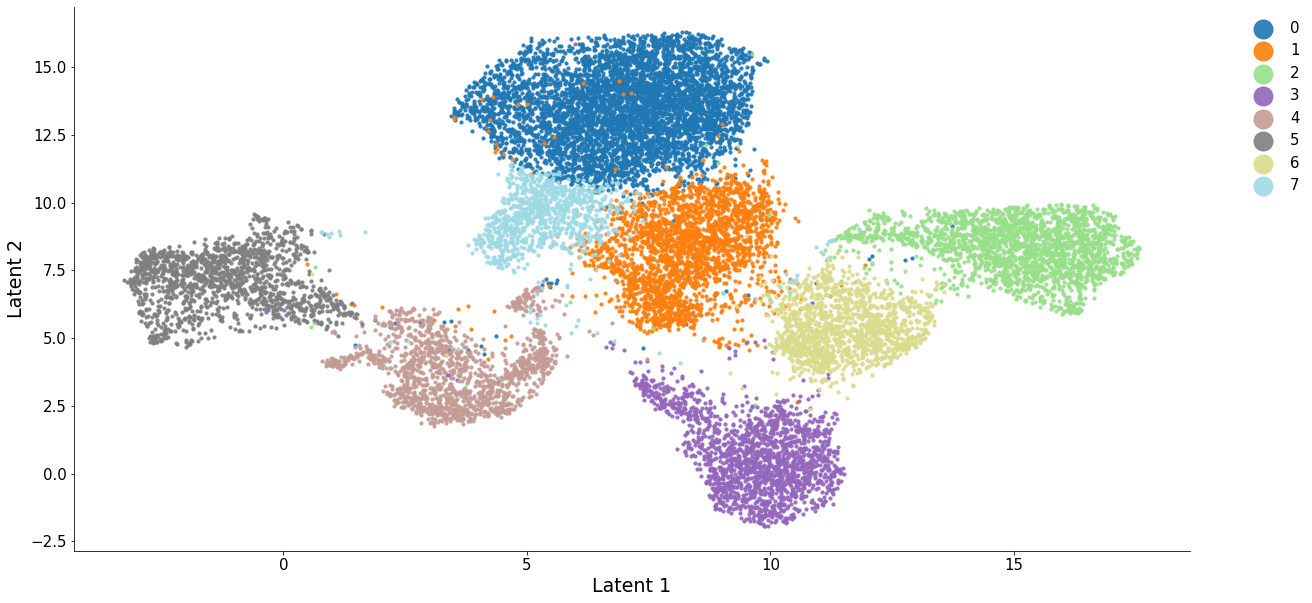

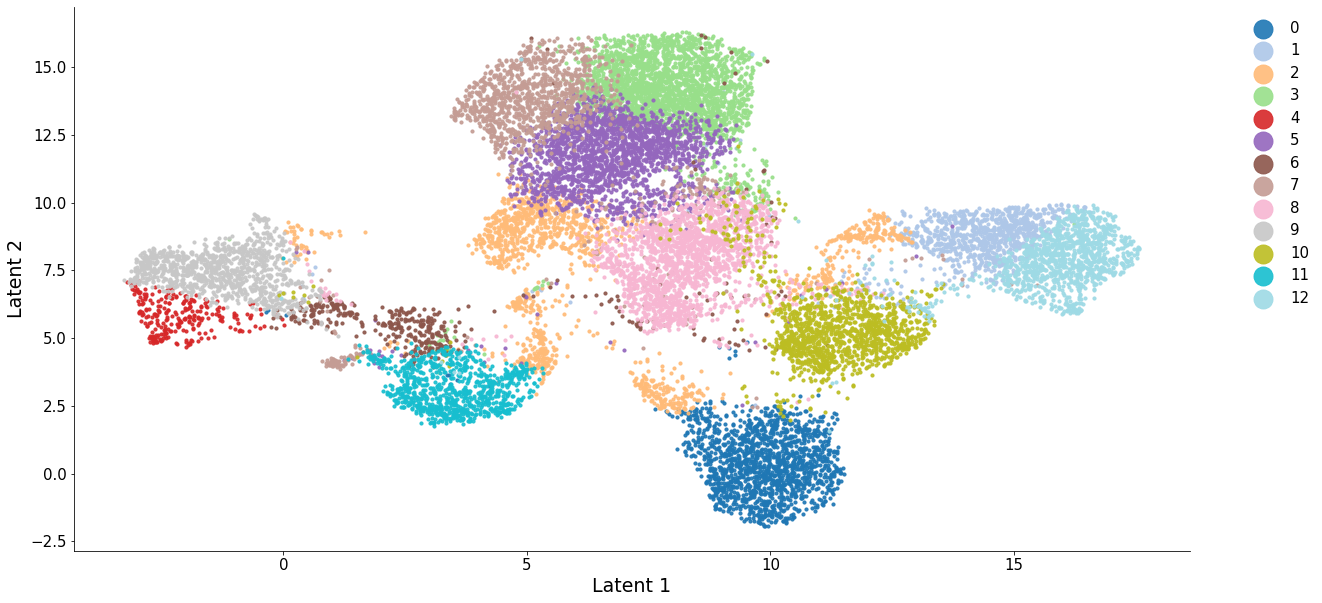

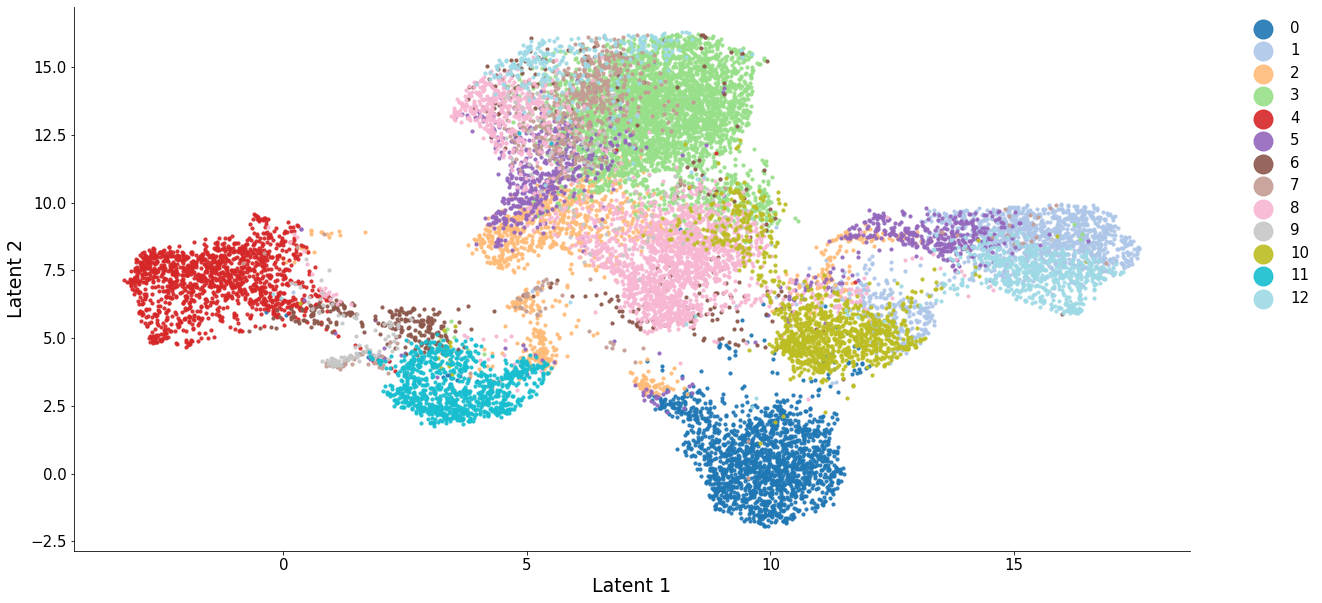

In [18]:
kmeans_labels = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        kmeans_labels.append(labels[start_pointer:end_pointer])
        
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        kmeans_labels.append(labels[start_pointer:])
        
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        kmeans_labels.append(labels[start_pointer:end_pointer])
        
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", markerscale = 6)
utils.plot_latent_ext(x_umaps, annos = leiden_labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", markerscale = 6)
utils.plot_latent_ext(x_umaps, annos = kmeans_labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", markerscale = 6)
utils.plot_latent_ext(x_umaps, annos = cfrm_labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent", markerscale = 6)

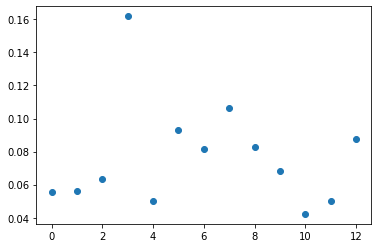

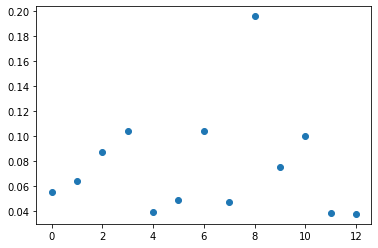

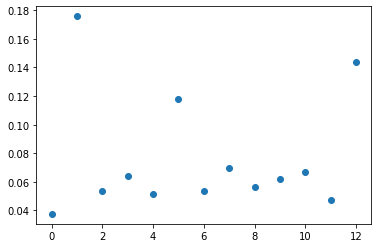

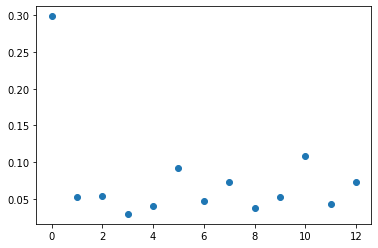

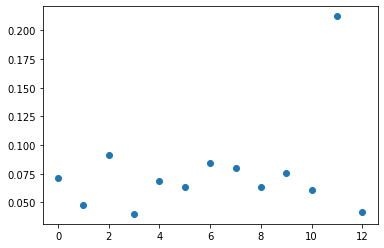

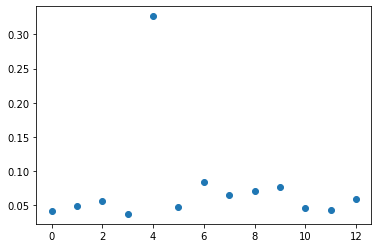

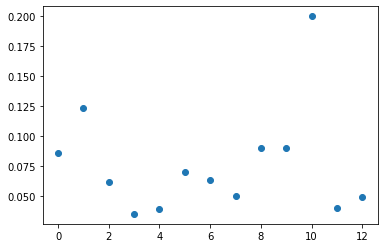

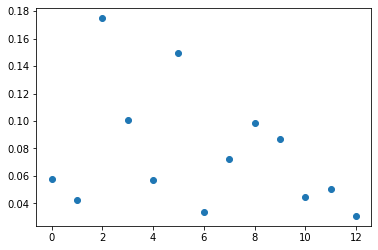

In [19]:
# using leiden to cluster, then change the cell factor to binary according to the cluster assignment. rerun the model
n_clusts = np.max(np.concatenate(leiden_labels, axis = 0)) + 1
clust_dims = []
for clusters in range(n_clusts):
    clust_cells = []
    for batch in range(0,4):
        idxs = np.where(leiden_labels[batch] == clusters)[0]
        clust_cells.append(zs[batch][idxs, :])
    clust_cells = np.concatenate(clust_cells, axis = 0)
    clust_centroid = np.mean(clust_cells, axis = 0)
    clust_dim = np.argmax(clust_centroid)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(np.arange(13), clust_centroid)
    
    # hard assignment, make sure softmax give largest value
    zs[batch][idxs, :] = 0
    zs[batch][idxs, clust_dim] = 10000
    clust_dims.append(clust_dim)

In [20]:
# feed new zs as cell embedding into the cfrm model
# some dimensions of zs is empty (nfactors > nclusters), 
# but keep it this way as it will not have any effect on the final result

zs = [torch.FloatTensor(z).to(device) for z in zs]
model1.retrain(C_cells = zs, T = 3000)

Epoch 100, Validating Loss: -135.3862
	 loss 1: 164.44867
	 loss 2: 0.00000
	 loss 3: -299.83487
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: -137.1888
	 loss 1: 162.76212
	 loss 2: 0.00000
	 loss 3: -299.95096
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 300, Validating Loss: -137.6768
	 loss 1: 162.30225
	 loss 2: 0.00000
	 loss 3: -299.97906
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: -137.7701
	 loss 1: 162.21985
	 loss 2: 0.00000
	 loss 3: -299.98993
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: -137.9415
	 loss 1: 162.04781
	 loss 2: 0.00000
	 loss 3: -299.98926
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: -137.9764
	 loss 1: 162.01634
	 loss 2: 0.00000
	 loss 3: -299.99271
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: -138.3022
	 loss 1: 161.68932
	 loss 2: 0.00000
	 loss 3: -299.99149
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: -138.2624
	 loss 1: 161.72456
	 loss 2: 0

[-135.38619995117188,
 -137.1888427734375,
 -137.67681884765625,
 -137.77008056640625,
 -137.9414520263672,
 -137.9763641357422,
 -138.3021697998047,
 -138.2624053955078,
 -138.43374633789062,
 -138.42987060546875,
 -138.63348388671875,
 -138.63140869140625,
 -138.78384399414062,
 -138.87977600097656,
 -138.9879913330078,
 -138.9883575439453,
 -139.11993408203125,
 -139.0982666015625,
 -139.1746063232422,
 -139.2834014892578,
 -139.15872192382812,
 -139.3588409423828,
 -139.37551879882812,
 -139.48281860351562,
 -139.4727325439453,
 -139.68838500976562,
 -139.69332885742188,
 -139.8118438720703,
 -139.84713745117188,
 -139.67031860351562]

## Post-processing (not necessary in this case)

In [170]:
import importlib 
importlib.reload(quantile)

<module 'quantile' from '../src/quantile.py'>

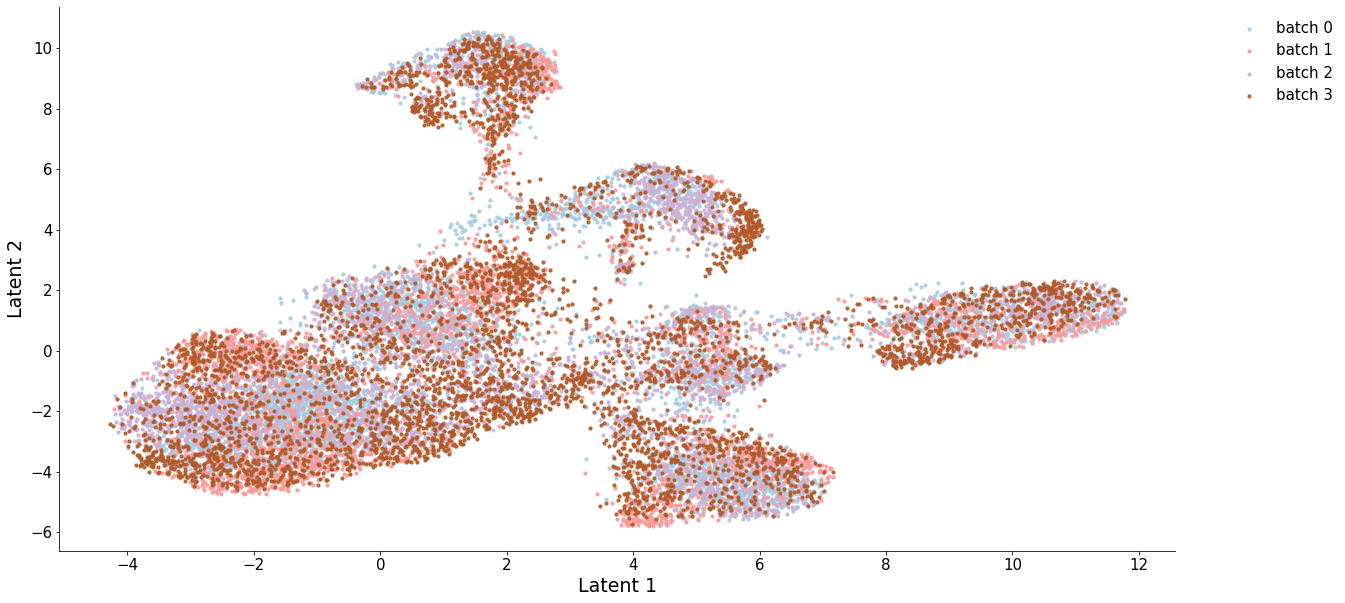

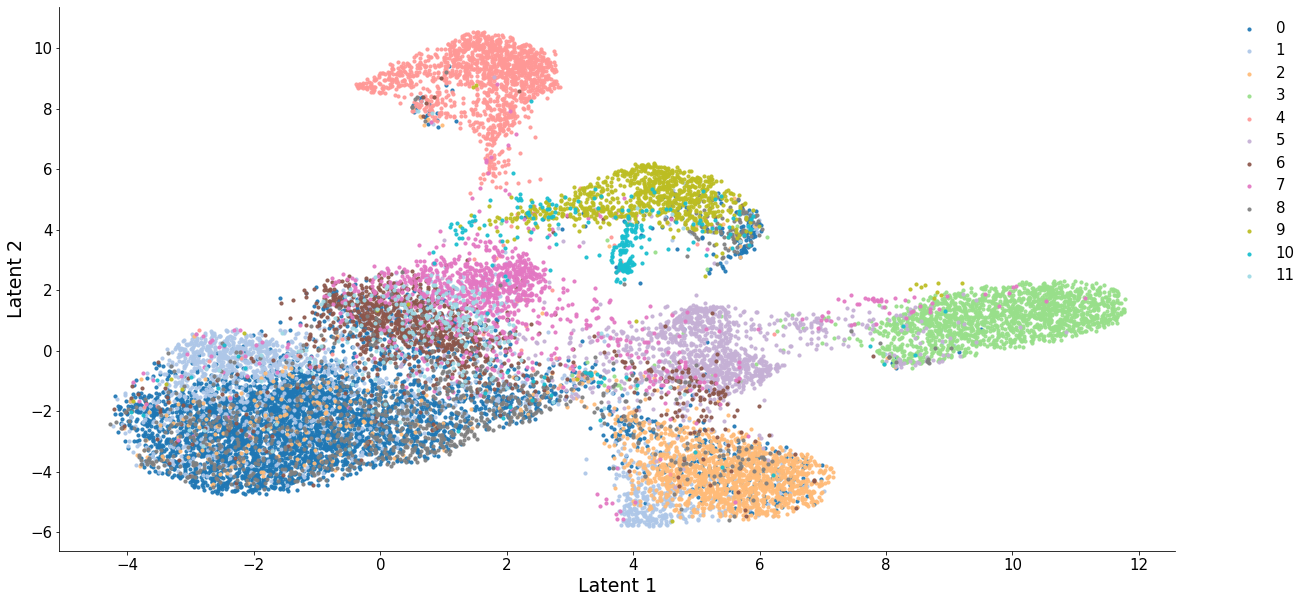

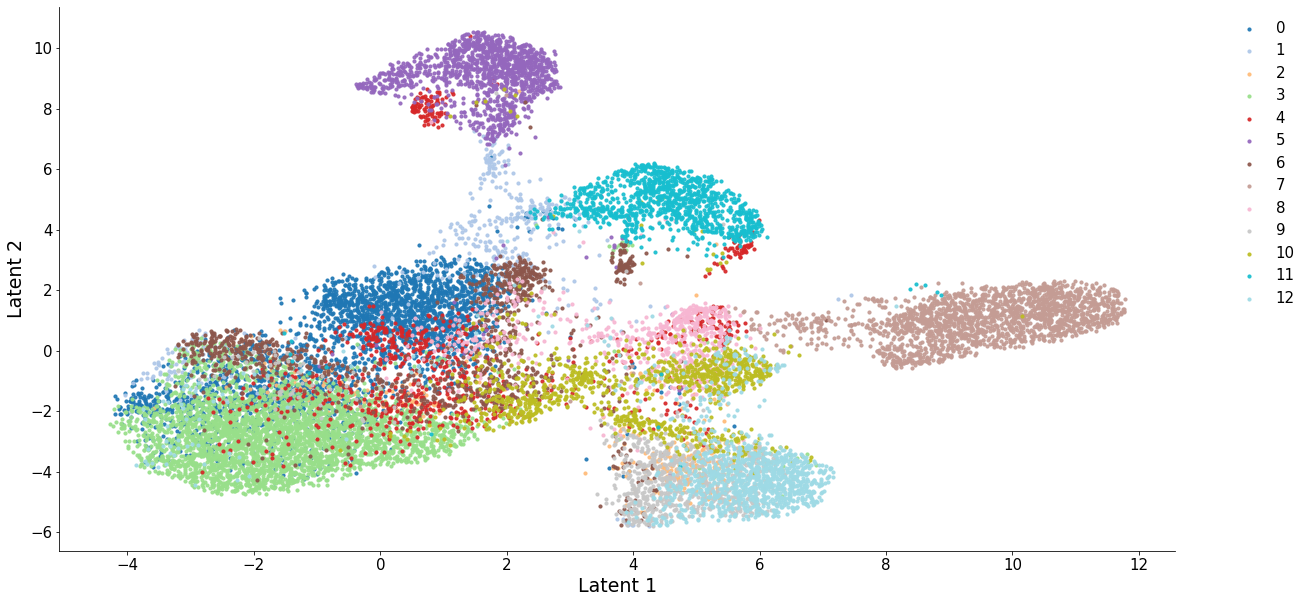

In [17]:
# Quantile normalization, result not good

umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4) 

zs = []
labels = []
pre_labels = []
for batch in range(4):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())

zs2, pre_labels = quantile.quantile_norm(zs)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, figsize = (20,10), axis_label = "Latent")


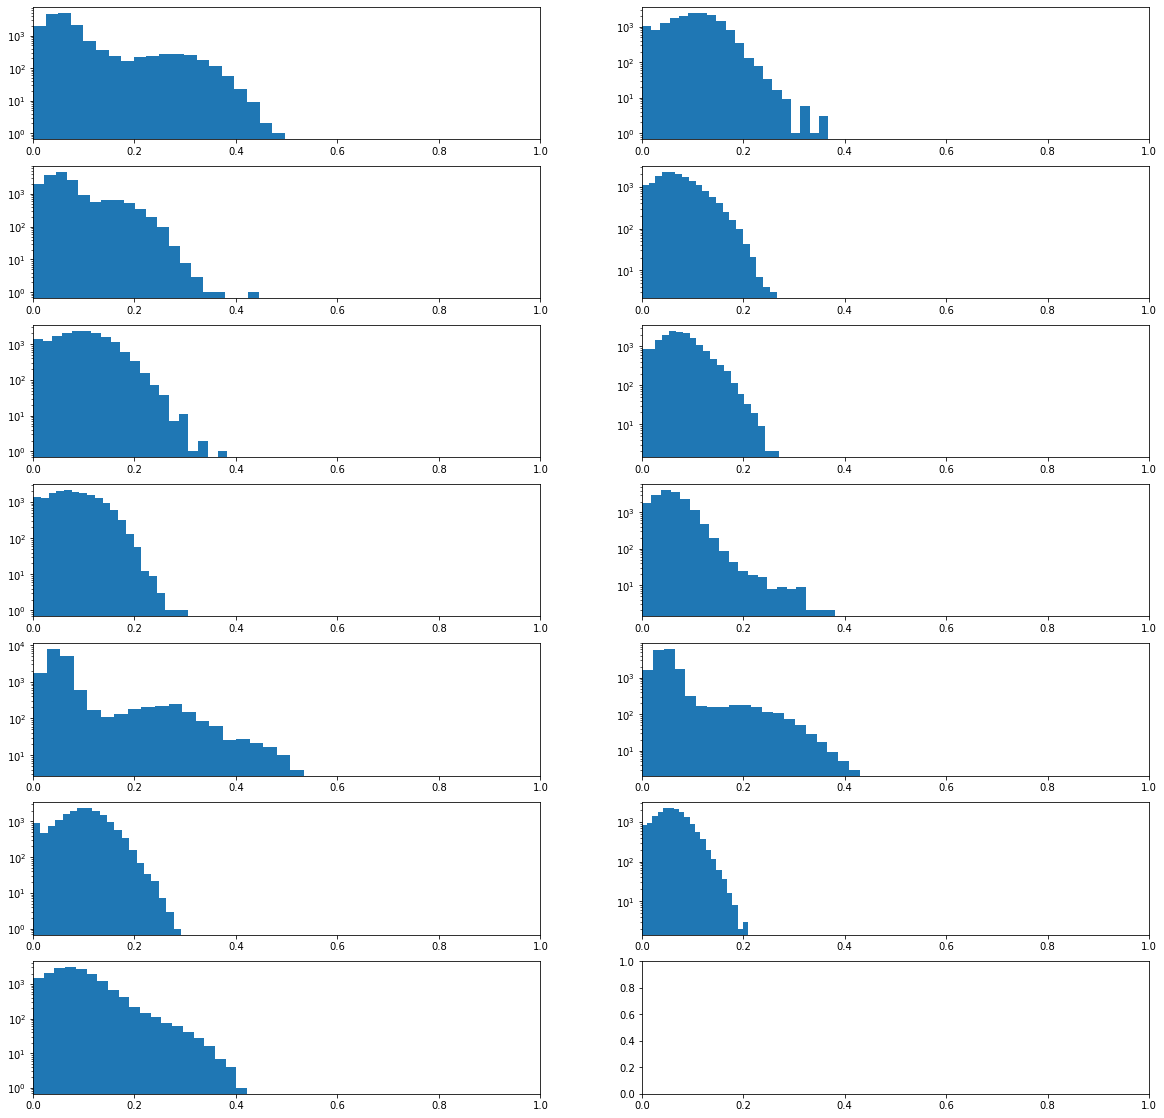

In [172]:
C_cells = np.concatenate([model1.softmax(x).data.cpu().numpy() for x in model1.C_cells], axis = 0)
pred_labels = np.concatenate([x for x in pre_labels], axis = 0)
nrows = np.ceil(C_cells.shape[1]/2).astype('int32')
ncols = 2
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(C_cells.shape[1]):
    _ = axs[i%nrows, i//nrows].hist(C_cells[:,i].reshape(-1), bins = 20)
    axs[i%nrows, i//nrows].set_xlim([0,1])
    axs[i%nrows, i//nrows].set_yscale('log')

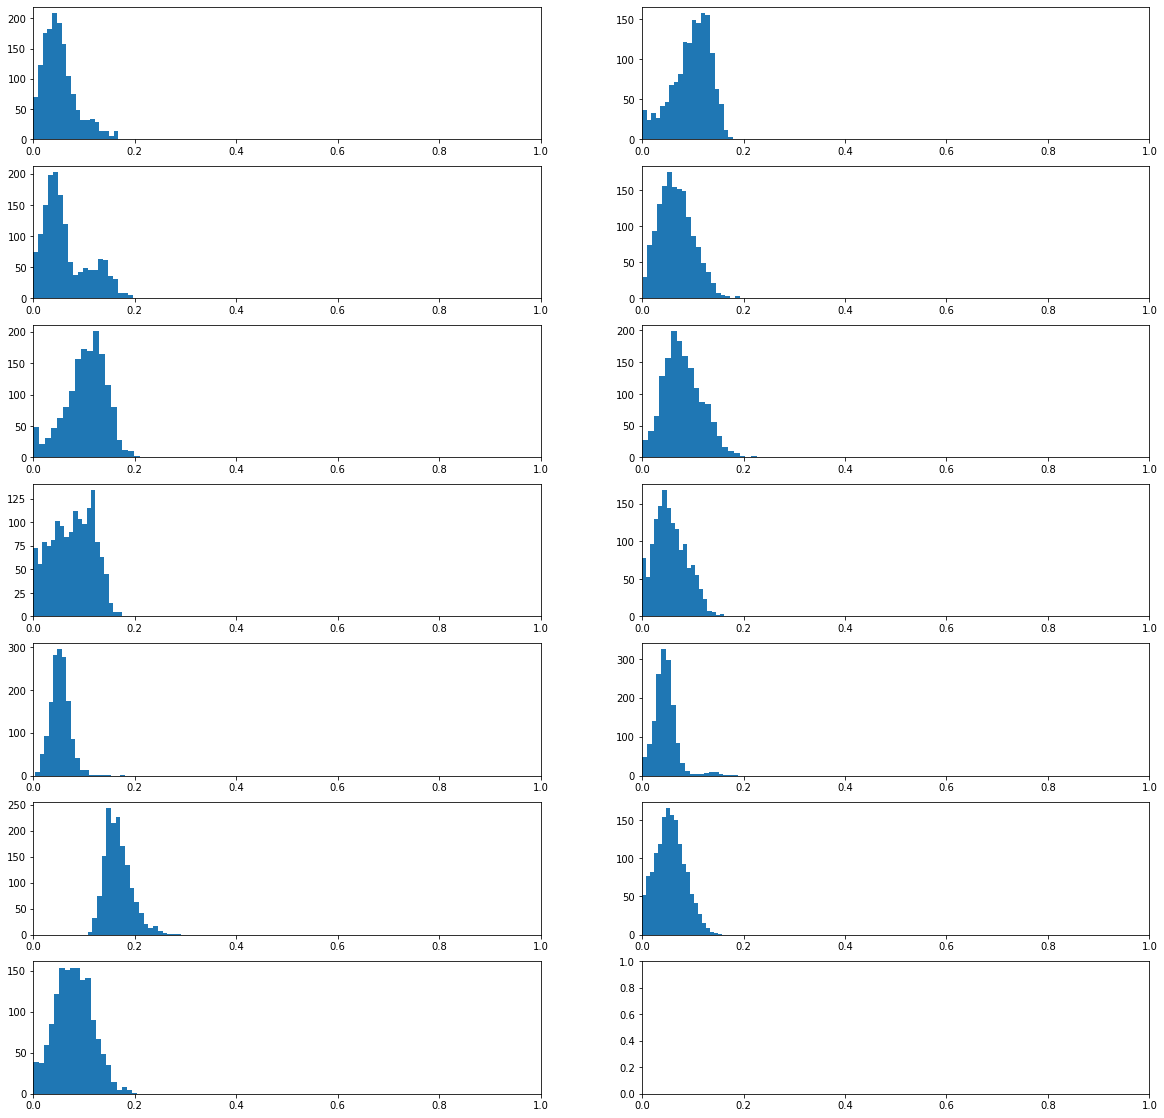

In [173]:
C_cells_5 = C_cells[pred_labels == 5, :]
nrows = np.ceil(C_cells_5.shape[1]/2).astype('int32')
ncols = 2
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(C_cells_5.shape[1]):
    _ = axs[i%nrows, i//nrows].hist(C_cells_5[:,i].reshape(-1), bins = 20)
    axs[i%nrows, i//nrows].set_xlim([0,1])

<AxesSubplot:>

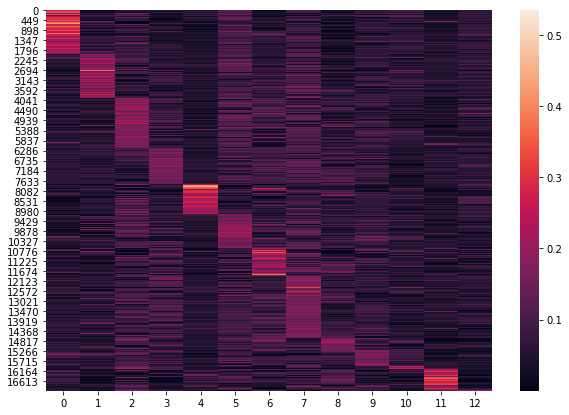

In [174]:
import seaborn as sns
C_cells_arranged = np.concatenate([C_cells[pred_labels == x, :] for x in range(K)])
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot()
sns.heatmap(pd.DataFrame(data = C_cells_arranged), ax = ax)

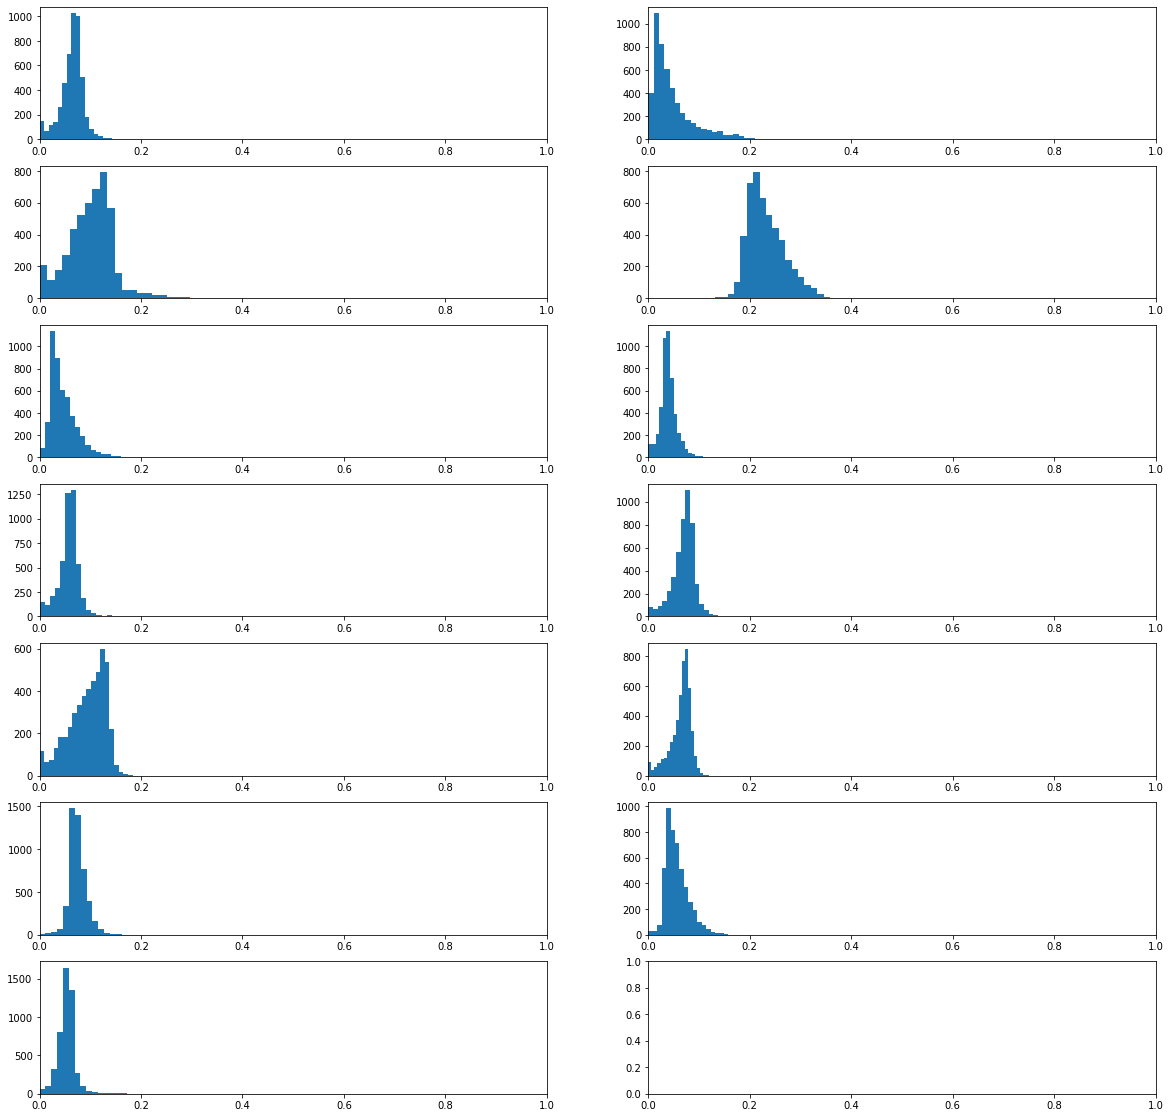

In [175]:
mod = 0
nrows = np.ceil(model1.C_feats[mod].shape[1]/2).astype('int32')
ncols = 2
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(model1.C_feats[mod].shape[1]):
    _ = axs[i%nrows, i//nrows].hist(model1.softmax(model1.C_feats[mod]).data.cpu().numpy()[:,i].reshape(-1), bins = 20)
    axs[i%nrows, i//nrows].set_xlim([0,1])

In [ ]:
# scDART flavor

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(4):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = None, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


## Analyzing the DE genes

Markers for the 


In [21]:
C_genes = model1.findMarkers(truncate = False)

In [22]:
n_selected = 100
for mod in range(len(model1.mods)):
    for clust in range(C_genes[mod].shape[1]):
        factor = "factor_" + str(clust)
        factor_values = C_genes[mod].loc[:, [factor]]
        factor_values = factor_values.sort_values(by = factor, ascending = False)[:n_selected]
        if not os.path.exists('PBMC/' + model1.mods[mod] + "_soft"):
            os.makedirs('PBMC/' + model1.mods[mod] + "_soft")
        factor_values.to_csv('PBMC/' + model1.mods[mod] + "_soft/clust_" + str(clust) + ".csv")

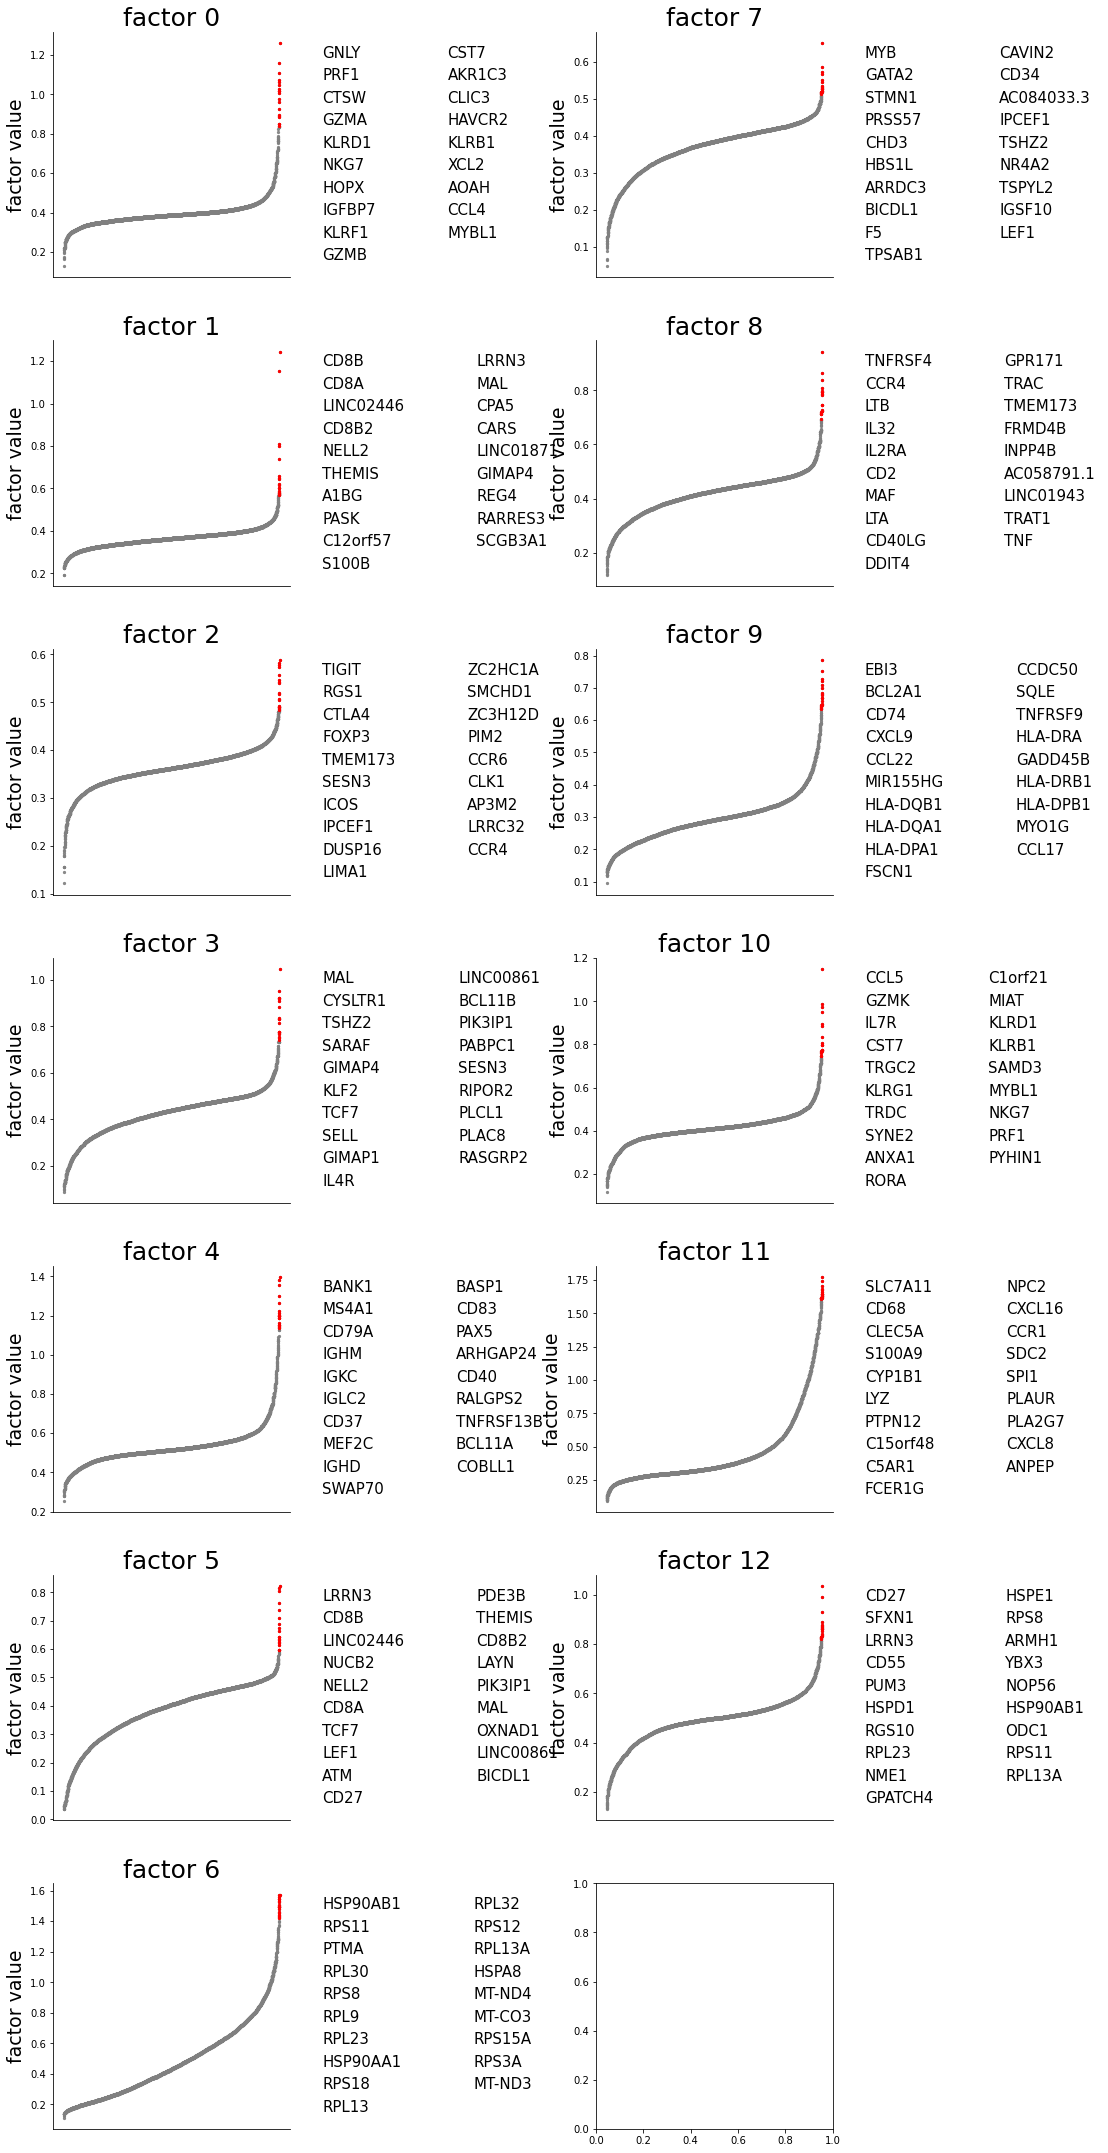

In [21]:
# plot the result from hard method
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,30), save_as = "PBMC/plots/gene_factors_soft.png", title = None)


In [34]:
marker = pd.read_csv("PBMC/MarkerGenes.csv")
marker.index = marker["MarkerGenes"].values

pred_markers = []
for clust in range(13):
    factor = "factor_" + str(clust)
    pred_marker = pd.read_csv("PBMC/rna_soft/clust_" + str(clust) + ".csv", index_col = 0)
    pred_markers.append(pred_marker)
    assert pred_marker.shape[0] == 100

for clust, pred_marker in enumerate(pred_markers):
    # find overlapped markers
    overlapped_marker = [x for x in set(pred_marker.index.values).intersection(set(marker.index.values))]  
    overlapped_marker = pd.concat((pred_marker.loc[overlapped_marker, :],  marker.loc[overlapped_marker, ["MarkerGenes", "Cell types(II)", "Cell types(I)", "Description"]]), axis = 1)
    overlapped_marker = overlapped_marker.sort_values("factor_" + str(clust))[::-1]
    overlapped_marker = overlapped_marker.drop(["MarkerGenes"], axis = 1)
    overlapped_marker.to_csv("PBMC/rna_soft/overlap_marker_clust_" + str(clust) + ".csv")
    display(overlapped_marker)
    

factor_0                Cell types(II)  Cell types(I)  \
GNLY    1.260504                      NK cells       NK cells   
KLRD1   1.065382                      NK cells       NK cells   
NKG7    1.049013                      NK cells       NK cells   
KLRF1   1.017212                      NK cells       NK cells   
GZMB    1.006494  Plasmacytoid dendritic cells  Myeloid cells   
KLRB1   0.891253                      NK cells       NK cells   
FCGR3A  0.778891             FCGR3A+ monocytes  Myeloid cells   
KLRC1   0.765243                      NK cells       NK cells   
NCAM1   0.722713                      NK cells       NK cells   
NCR1    0.693026                      NK cells       NK cells   

                                              Description  
GNLY    This protein is present in cytotoxic granules ...  
KLRD1   Key inhibitory receptor on natural killer (NK)...  
NKG7    NKG7 (Natural Killer Cell Granule Protein 7) i...  
KLRF1   Involved in the natural killer (NK)-mediated c...  
GZMB    This gene encodes a member of the granzyme sub...  
KLRB1   Plays an inhibitory role on natural killer (NK...  
FCGR3A  This gene encodes a receptor for the Fc portio...  
KLRC1   Key inhibitory receptor on natural killer (NK)...  
NCAM1   This protein is also involved in the expansion...  
NCR1    Cytotoxicity-activating receptor that may cont...

factor_1          Cell types(II) Cell types(I)  \
CD8B  1.244432  Cytotoxic CD8+ T cells       T cells   
CD8A  1.154115  Cytotoxic CD8+ T cells       T cells   
IL7R  0.494872          Memory T cells       T cells   
CD3D  0.476378                 T cells       T cells   
CD3E  0.473739                 T cells       T cells   

                                            Description  
CD8B  The CD8 antigen is a cell surface glycoprotein...  
CD8A  The CD8 antigen is a cell surface glycoprotein...  
IL7R  The protein encoded by this gene is a receptor...  
CD3D  The protein encoded by this gene is part of th...  
CD3E  The protein encoded by this gene is the CD3-ep...

factor_2           Cell types(II) Cell types(I)  \
CTLA4  0.578253  Regulatory CD4+ T cells       T cells   
FOXP3  0.573875  Regulatory CD4+ T cells       T cells   
CD4    0.475160      Helper CD4+ T cells       T cells   

                                             Description  
CTLA4  Inhibitory receptor acting as a major negative...  
FOXP3  Transcriptional regulator which is crucial for...  
CD4    CD4 (cluster of differentiation 4) is a glycop...

factor_3       Cell types(II) Cell types(I)  \
IL7R   0.73453       Memory T cells       T cells   
CD4    0.61372  Helper CD4+ T cells       T cells   

                                            Description  
IL7R  The protein encoded by this gene is a receptor...  
CD4   CD4 (cluster of differentiation 4) is a glycop...

factor_4 Cell types(II) Cell types(I)  \
MS4A1  1.382259        B cells       B cells   
CD79A  1.353898        B cells       B cells   
CD37   1.215691        B cells       B cells   
CD79B  1.093764        B cells       B cells   
CD19   1.093267        B cells       B cells   
BLNK   1.038074        B cells       B cells   

                                             Description  
MS4A1  This gene encodes a B-lymphocyte surface molec...  
CD79A  This gene encodes the Ig-alpha protein of the ...  
CD37   CD37 (tetraspanin TSPAN26) is a B-cell surface...  
CD79B  This gene encodes the Ig-beta protein of the B...  
CD19   Expression of this cell surface protein is res...  
BLNK   This gene encodes a cytoplasmic linker or adap...

factor_5          Cell types(II) Cell types(I)  \
CD8B   0.814999  Cytotoxic CD8+ T cells       T cells   
CD8A   0.707696  Cytotoxic CD8+ T cells       T cells   
CD27   0.643975                 T cells       T cells   
GZMK   0.548267  Cytotoxic CD8+ T cells       T cells   
KLRC1  0.548186                NK cells      NK cells   
KLRK1  0.528106                NK cells      NK cells   

                                             Description  
CD8B   The CD8 antigen is a cell surface glycoprotein...  
CD8A   The CD8 antigen is a cell surface glycoprotein...  
CD27   The protein encoded by this gene is a member o...  
GZMK   This gene product is a member of a group of re...  
KLRC1  Key inhibitory receptor on natural killer (NK)...  
KLRK1  The NKG2 gene family is located within the NK ...

Empty DataFrame
Columns: [factor_6, Cell types(II), Cell types(I), Description]
Index: []

factor_7           Cell types(II) Cell types(I)  \
CTLA4  0.494387  Regulatory CD4+ T cells       T cells   
FOXP3  0.480239  Regulatory CD4+ T cells       T cells   

                                             Description  
CTLA4  Inhibitory receptor acting as a major negative...  
FOXP3  Transcriptional regulator which is crucial for...

factor_8           Cell types(II) Cell types(I)  \
IL2RA  0.798389  Regulatory CD4+ T cells       T cells   
CTLA4  0.668746  Regulatory CD4+ T cells       T cells   
CD28   0.653366                  T cells       T cells   
FOXP3  0.652626  Regulatory CD4+ T cells       T cells   
CD3D   0.614570                  T cells       T cells   
CD4    0.579558      Helper CD4+ T cells       T cells   

                                             Description  
IL2RA  Receptor for interleukin-2. The receptor is in...  
CTLA4  Inhibitory receptor acting as a major negative...  
CD28   The protein encoded by this gene is essential ...  
FOXP3  Transcriptional regulator which is crucial for...  
CD3D   The protein encoded by this gene is part of th...  
CD4    CD4 (cluster of differentiation 4) is a glycop...

factor_9                Cell types(II)  Cell types(I)  \
FOXP3    0.585851       Regulatory CD4+ T cells        T cells   
IL2RA    0.537470       Regulatory CD4+ T cells        T cells   
TSPAN13  0.517994  Plasmacytoid dendritic cells  Myeloid cells   

                                               Description  
FOXP3    Transcriptional regulator which is crucial for...  
IL2RA    Receptor for interleukin-2. The receptor is in...  
TSPAN13  The protein encoded by this gene is a member o...

factor_10          Cell types(II) Cell types(I)  \
GZMK    0.985673  Cytotoxic CD8+ T cells       T cells   
IL7R    0.971353          Memory T cells       T cells   
KLRD1   0.773026                NK cells      NK cells   
KLRB1   0.770437                NK cells      NK cells   
NKG7    0.761123                NK cells      NK cells   
KLRC1   0.694949                NK cells      NK cells   

                                             Description  
GZMK   This gene product is a member of a group of re...  
IL7R   The protein encoded by this gene is a receptor...  
KLRD1  Key inhibitory receptor on natural killer (NK)...  
KLRB1  Plays an inhibitory role on natural killer (NK...  
NKG7   NKG7 (Natural Killer Cell Granule Protein 7) i...  
KLRC1  Key inhibitory receptor on natural killer (NK)...

factor_11                Cell types(II)  Cell types(I)  \
CD68      1.745970                   Macrophages  Myeloid cells   
S100A9    1.682600               CD14+ monocytes  Myeloid cells   
LYZ       1.660447               CD14+ monocytes  Myeloid cells   
S100A8    1.567247               CD14+ monocytes  Myeloid cells   
IL3RA     1.565130  Plasmacytoid dendritic cells  Myeloid cells   
CSF1R     1.452176                   Macrophages  Myeloid cells   
S100A12   1.408580               CD14+ monocytes  Myeloid cells   
NRP1      1.404275  Plasmacytoid dendritic cells  Myeloid cells   
LGALS3    1.400058               CD14+ monocytes  Myeloid cells   

                                               Description  
CD68     This gene encodes a 110-kD transmembrane glyco...  
S100A9   We have identified members of the S100 protein...  
LYZ      Lysozymes have primarily a bacteriolytic funct...  
S100A8   Expression is highly induced in CD14(+) monocy...  
IL3RA    The protein encoded by this gene is an interle...  
CSF1R    The protein encoded by this gene is the recept...  
S100A12  Acts as a monocyte and mast cell chemoattractant.  
NRP1     This gene encodes one of two neuropilins, whic...  
LGALS3   Involved in acute inflammatory responses inclu...

factor_12          Cell types(II) Cell types(I)  \
CD27   1.037092                 T cells       T cells   
CD3D   0.793843                 T cells       T cells   
CD3G   0.771918                 T cells       T cells   
CD8B   0.748229  Cytotoxic CD8+ T cells       T cells   
CD3E   0.715092                 T cells       T cells   

                                            Description  
CD27  The protein encoded by this gene is a member o...  
CD3D  The protein encoded by this gene is part of th...  
CD3G  The protein encoded by this gene is the CD3-ga...  
CD8B  The CD8 antigen is a cell surface glycoprotein...  
CD3E  The protein encoded by this gene is the CD3-ep...

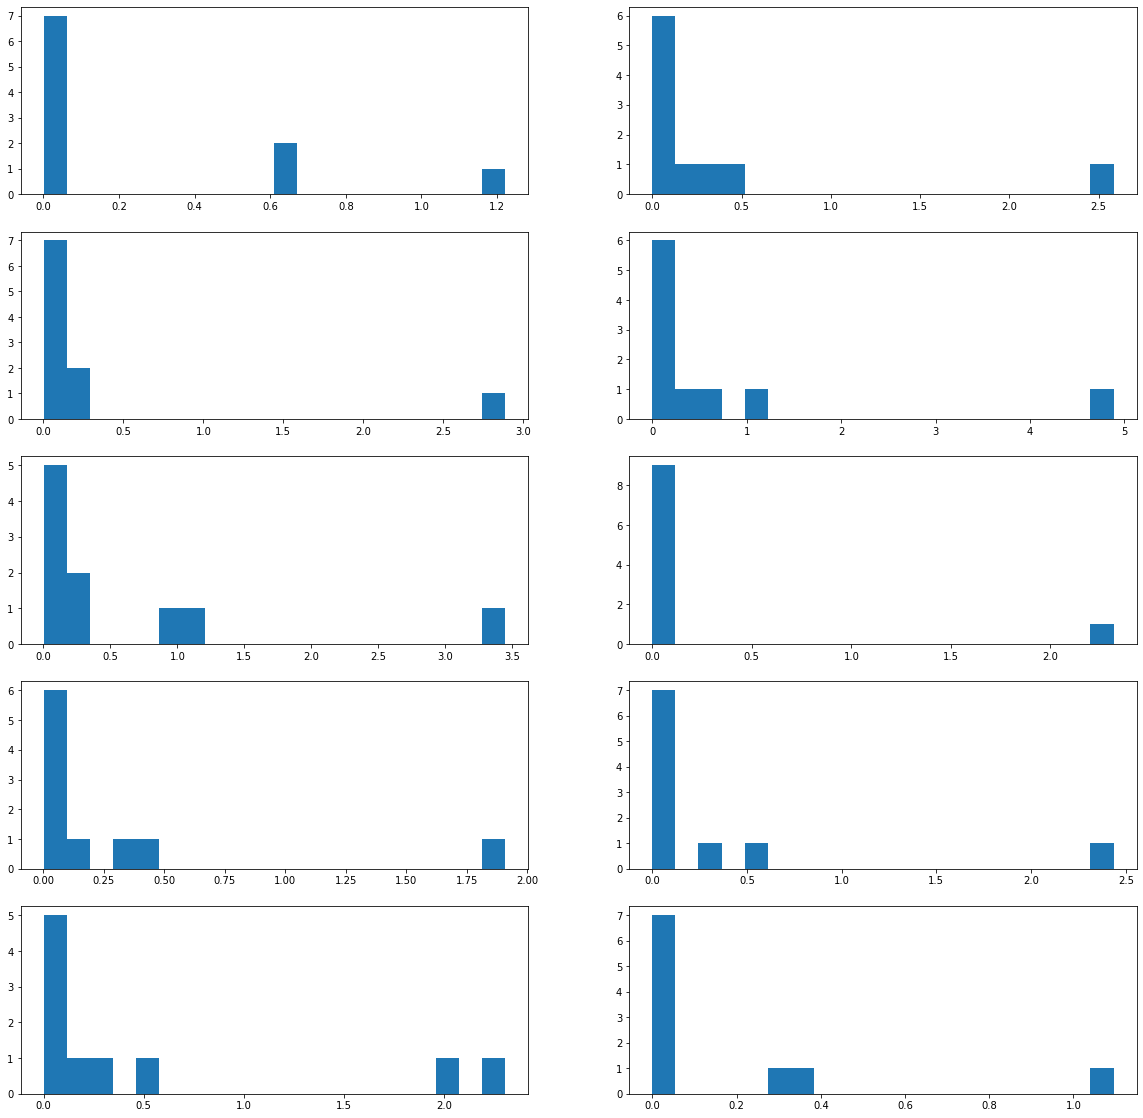

In [11]:
# Assos_score = np.abs(model1.A_assos[0].cpu().numpy())
Assos_score = model1.A_assos[0].cpu().numpy()
nrows = np.ceil(Assos_score.shape[0]/2).astype('int32')
ncols = 2

mod = 0
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(model1.C_feats[mod].shape[1]):
    _ = axs[i%nrows, i//nrows].hist(Assos_score[i,:], bins = 20)
#     axs[i%nrows, i//nrows].set_xlim([0,1])

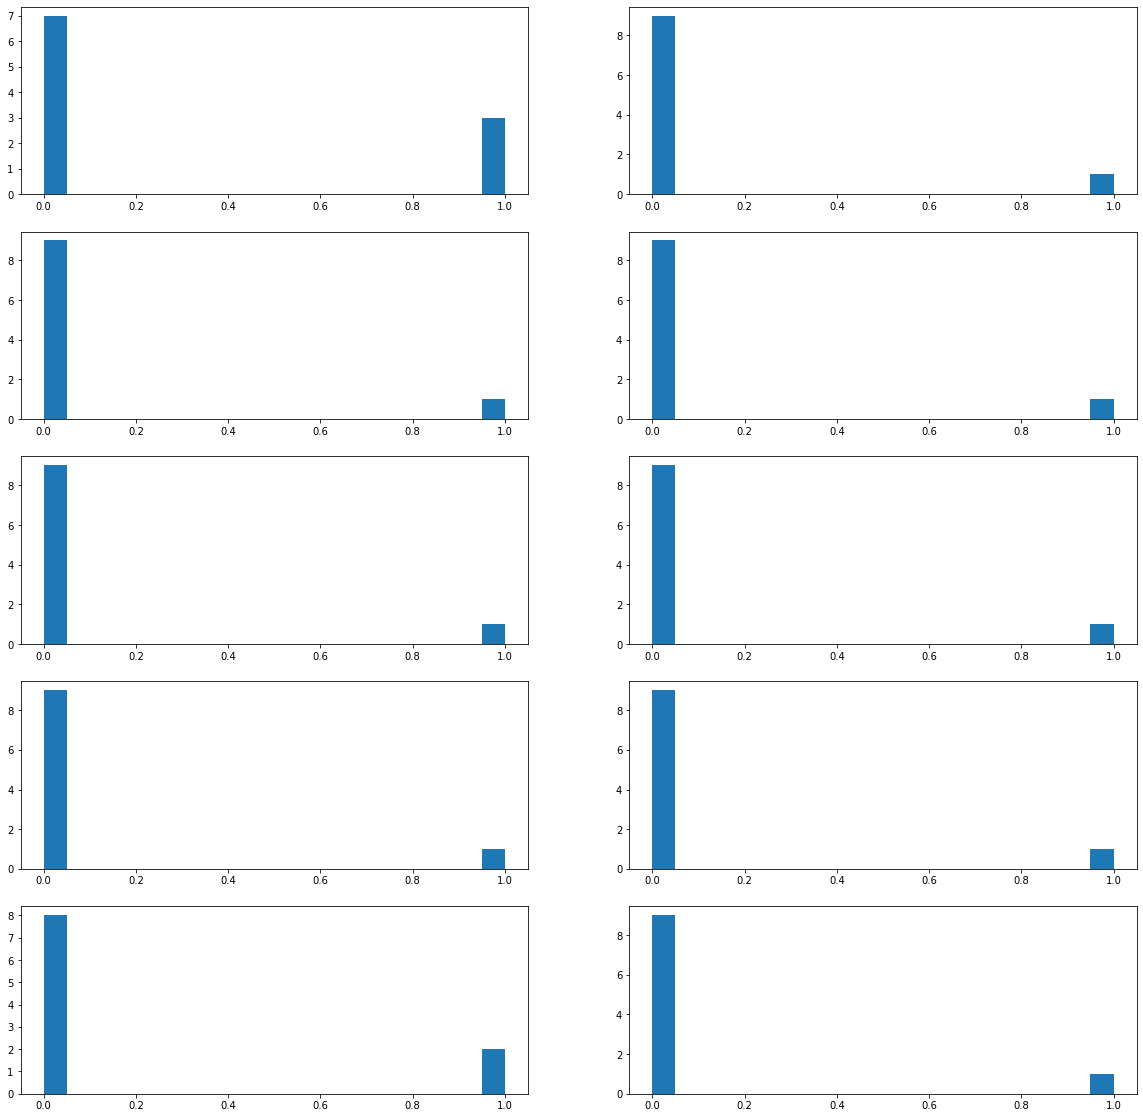

In [12]:
Assos_score = model1.binary_A_assos[0].astype(np.int)
nrows = np.ceil(Assos_score.shape[0]/2).astype('int32')
ncols = 2

mod = 0
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(model1.C_feats[mod].shape[1]):
    _ = axs[i%nrows, i//nrows].hist(Assos_score[i,:], bins = 20)
#     axs[i%nrows, i//nrows].set_xlim([0,1])

In [14]:
# output de feature list
# for each modalities

de_feats = []
for mod in range(len(model1.binary_A_assos)):
    # create a de list for the current modality
    de_feats.append([])
    
    # extract the Association matrix
    binary_A_asso = model1.binary_A_assos[mod]
    A_asso = model1.A_assos[mod]
    
    # extract the feature factor
    binary_C_feat = model1.binary_C_feats[mod]
    C_feat = model1.C_feats[mod]
    
    # number of cell clusters
    n_clusts = binary_A_asso.shape[0]
    
    for clust in range(n_clusts):
        de_feats[-1].append({})
        # select the feature cluster correspond to each cell cluster
        feat_clusts = np.where(binary_A_asso[clust,:] == True)[0]
        # TODO: Add score metric
        for feat_clust in feat_clusts:
            # select differentially expressed features
            de_feat = [x for x in feats_name[mod][np.where(binary_C_feat[:,feat_clust] == True)[0]]]
            # scoring, consider both Association score and feature factor
            scores = [A_asso[clust, feat_clust].item() * x.item() for x in C_feat[np.where(binary_C_feat[:,feat_clust] == True)[0], feat_clust]]
            for i, feat in enumerate(de_feat):
                if feat in de_feats[-1][-1]:
                    # pass
                    de_feats[-1][-1][feat] += scores[i]
                else:
                    de_feats[-1][-1][feat] =  scores[i]
            
# save the result
for mod, de_feat in enumerate(de_feats):
    if not os.path.exists('PBMC/' + model1.mods[mod]):
        os.makedirs('PBMC/' + model1.mods[mod])
    for clust, de_feat_clust in enumerate(de_feat):
        de_feat_clust_df = pd.DataFrame.from_dict(de_feat_clust, orient = 'index', columns = ["score"]).sort_values(by = ["score"], ascending = False)
        de_feat_clust_df.to_csv('PBMC/' + model1.mods[mod] + "/clust_" + str(clust) + ".csv")

In [63]:
def plot_feat_factor(C_feats, figsize= (20,20), save_as = None, title = None, **kwargs):
    """\
    plot de feat curve

    C_feats:
    ---------
        dataframe of the shape (n_features, n_clusters)
    """
    
    _kwargs = {
        "s": 5,
        "alpha": 0.9,
        "fontsize": 15
    }
    _kwargs.update(kwargs)
    
    n_clusts = C_feats.shape[1]
    
    if n_clusts >= 2:
        nrows = np.ceil(n_clusts/2).astype('int32')
        ncols = 2
    elif n_clusts == 1:
        nrows = 1
        ncols = 1        
        

    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    
    if title:
        fig.suptitle("feature factor loadings", fontsize = 18)


    for clust in range(n_clusts):
        feat_factor = C_feats.iloc[:, clust].values.squeeze()
        # sort the value from the largest to the smallest
        indices = np.argsort(feat_factor)
        
        de_indices = indices[-1:-10:-1]
        
        if nrows != 1:
            axs[clust%nrows, clust//nrows].scatter(np.arange(0, 1, 1/feat_factor.shape[0]), 
                                           feat_factor[indices], color = "gray", alpha = _kwargs["alpha"], s =_kwargs["s"])
            
            for i, de_idx in enumerate(de_indices):
                axs[clust%nrows, clust//nrows].scatter(np.arange(0, 1, 1/feat_factor.shape[0])[-i -1], 
                                                       feat_factor[de_idx], c = "red", s = _kwargs["s"], 
                                                       label = C_feats.index.values[de_idx])
                

            axs[clust%nrows, clust//nrows].set_title("factor " + str(clust), fontsize = 25)
            axs[clust%nrows, clust//nrows].set_ylabel("factor value", fontsize = 19)
            axs[clust%nrows, clust//nrows].set_xticks([])
            axs[clust%nrows, clust//nrows].spines['right'].set_visible(False)
            axs[clust%nrows, clust//nrows].spines['top'].set_visible(False)
            leg = axs[clust%nrows, clust//nrows].legend(bbox_to_anchor=(0.9,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False)
            for item in leg.legendHandles:
                item.set_visible(False)
          
        elif nrows == 1 and ncols == 1:
           
            axs.scatter(np.arange(0, 1, 1/feat_factor.shape[0]), feat_factor[indices], color = 'gray', alpha = _kwargs["alpha"], s =_kwargs["s"])

            for i, de_idx in enumerate(de_indices):
                axs.scatter(np.arange(0, 1, 1/feat_factor.shape[0])[-i -1], 
                            feat_factor[de_idx], c = "red", s = _kwargs["s"], 
                            label = C_feats.index.values[de_idx])
                
            axs.set_title("factor " + str(clust), fontsize = 25)
            axs.set_ylabel("factor value", fontsize = 19)
            axs.set_xticks([])
            axs.spines['right'].set_visible(False)
            axs.spines['top'].set_visible(False)
            leg = axs.legend(bbox_to_anchor=(0.9,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False)
            for item in leg.legendHandles:
                item.set_visible(False)

        else:
            axs[clust].scatter(np.arange(0, 1, 1/feat_factor.shape[0]), feat_factor[indices], color = 'gray', alpha = _kwargs["alpha"], s =_kwargs["s"])

            for i, de_idx in enumerate(de_indices):
                axs[clust].scatter(np.arange(0, 1, 1/feat_factor.shape[0])[-i -1], 
                                   feat_factor[de_idx], c = "red", s = _kwargs["s"], 
                                   label = C_feats.index.values[de_idx])
                
            axs[clust].set_title("factor " + str(i), fontsize = 25)
            axs[clust].set_ylabel("factor value", fontsize = 19)
            axs[clust].set_xticks([])
            axs[clust].spines['right'].set_visible(False)
            axs[clust].spines['top'].set_visible(False)
            leg = axs[clust].legend(bbox_to_anchor=(0.9,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False)
            for item in leg.legendHandles:
                item.set_visible(False)
 
    fig.tight_layout(pad=0.0)
    if save_as!= None:
        fig.savefig(save_as, bbox_inches = 'tight')
    
    plt.show()     

In [69]:
# Just factor loading, model1.C_feats[2] is the protein
C_protein = model1.softmax(model1.C_feats[2]).data.cpu().numpy()
C_protein = pd.DataFrame(data = C_protein, index = proteins, columns = ["factor_" + str(i) for i in range(C_protein.shape[1])])
plot_feat_factor(C_protein, figsize = (10,20), save_as = None, title = None)


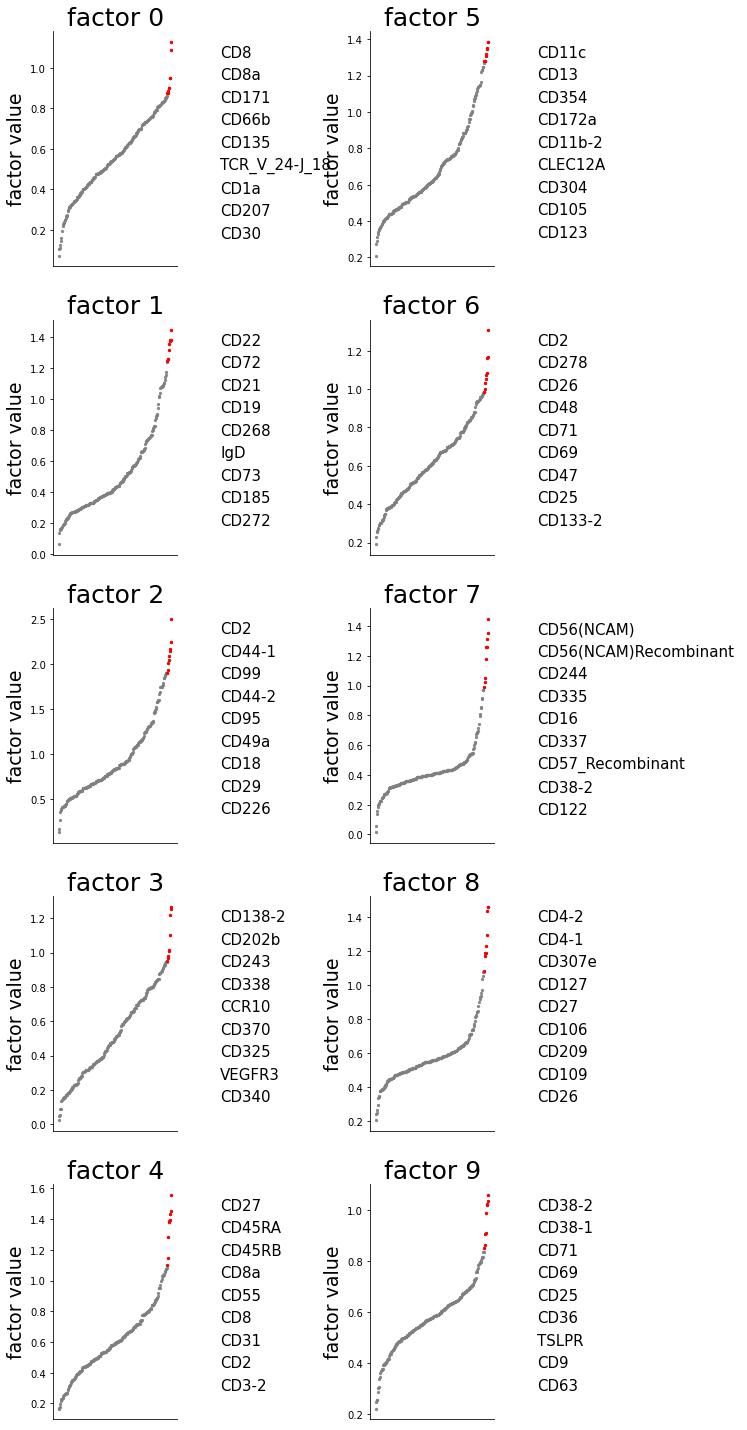

In [68]:
# Factor loading with association matrix, more like the de features
C_protein = model1.softmax(model1.C_feats[2]).data.cpu().numpy() @ model1.A_assos[2].data.cpu().numpy().T
C_protein = pd.DataFrame(data = C_protein, index = proteins, columns = ["factor_" + str(i) for i in range(C_protein.shape[1])])
plot_feat_factor(C_protein, figsize= (10,20), save_as = None, title = None)


## Infer cross modalities relationship

In [9]:
# RNA & ATAC
RNA_ATAC = utils.infer_interaction(model1.C_feats[0].data.cpu().numpy(), model1.C_feats[1].data.cpu().numpy())

# RNA & Protein
RNA_PROTEIN = utils.infer_interaction(model1.C_feats[0].data.cpu().numpy(), model1.C_feats[2].data.cpu().numpy())

# Protein & ATAC
PROTEIN_ATAC = utils.infer_interaction(model1.C_feats[2].data.cpu().numpy(), model1.C_feats[1].data.cpu().numpy())

In [10]:
import pandas as pd
import numpy as np

from sklearn.metrics import precision_recall_curve, roc_curve, auc
from itertools import product, permutations, combinations, combinations_with_replacement

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,roc_curve,auc,RocCurveDisplay, average_precision_score, roc_auc_score


def compute_auc(estm_adj, gt_adj, directed = False):
    """\
    Description:
    ------------
        calculate AUPRC and AUROC
    Parameters:
    ------------
        estm_adj: predict graph adjacency matrix
        gt_adj: ground truth graph adjacency matrix
        directed: the directed estimation or not
    Return:
    ------------
        prec: precision
        recall: recall
        fpr: false positive rate
        tpr: true positive rate
        AUPRC, AUROC
    """
    estm_norm_adj = np.abs(estm_adj)/np.max(np.abs(estm_adj) + 1e-12)
    
    if np.max(estm_norm_adj) == 0:
        return 0, 0, 0, 0, 0, 0
    else:
        # assert np.abs(np.max(estm_norm_adj) - 1) < 1e-4
        if directed == False:
            gt_adj = ((gt_adj + gt_adj.T) > 0).astype(np.int)
        np.fill_diagonal(gt_adj, 0)
        np.fill_diagonal(estm_norm_adj, 0)
        rows, cols = np.where(gt_adj != 0)

        fpr, tpr, thresholds = roc_curve(y_true=gt_adj.reshape(-1,), y_score=estm_norm_adj.reshape(-1,), pos_label=1)
        prec, recall, thresholds = precision_recall_curve(y_true=gt_adj.reshape(-1,), probas_pred=estm_norm_adj.reshape(-1,), pos_label=1)

        # the same
        # AUPRC = average_precision_score(gt_adj.reshape(-1,), estm_norm_adj.reshape(-1,)) 

        return prec, recall, fpr, tpr, auc(recall, prec), auc(fpr, tpr)

In [14]:
# AUPRC
*_, AUPRC_rna_atac, AUROC_rna_atac = compute_auc(RNA_ATAC, interacts["rna_atac"], directed = True)
*_, AUPRC_rna_protein, AUROC_rna_protein = compute_auc(RNA_PROTEIN, interacts["rna_protein"], directed = True)

RNA_ATAC_rand = np.random.rand(RNA_ATAC.shape[0], RNA_ATAC.shape[1])
RNA_PROTEIN_rand = np.random.rand(RNA_PROTEIN.shape[0], RNA_PROTEIN.shape[1])

*_, AUPRC_rna_atac_rand, AUROC_rna_atac_rand = compute_auc(RNA_ATAC_rand, interacts["rna_atac"], directed = True)
*_, AUPRC_rna_protein_rand, AUROC_rna_protein_rand = compute_auc(RNA_PROTEIN_rand, interacts["rna_protein"], directed = True)

AUPRC_rna_atac_ratio = AUPRC_rna_atac/AUPRC_rna_atac_rand
AUPRC_rna_protein_ratio = AUPRC_rna_protein/AUPRC_rna_protein_rand

print("AUPRC (RNA & ATAC): {:.3f}".format(AUPRC_rna_atac_ratio))
print("AUPRC (RNA & protein): {:.3f}".format(AUPRC_rna_protein_ratio))


AUPRC (RNA & ATAC): 0.930
AUPRC (RNA & protein): 3.702
